# Machine Learning System Design


## Introduction and Initial Setup

In [4]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import json
import logging
import sys
from pathlib import Path

import ipytest

import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

import boto3
import sagemaker
from sagemaker.workflow.pipeline_context import LocalPipelineSession, PipelineSession
from sagemaker.workflow.steps import CacheConfig
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

CODE_FOLDER = Path("code")
CODE_FOLDER.mkdir(exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[01/24/25 19:17:21] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=916040;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=950062;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py#1278\1278]8;;\

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/anchit/Library/Application Support/sagemaker/config.yaml


In [5]:
logger = logging.getLogger("sagemaker.config")
logger.setLevel(logging.ERROR)

In [6]:
LOCAL_MODE = False

In [7]:
bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

COMET_API_KEY = os.environ.get("COMET_API_KEY", None)
COMET_PROJECT_NAME = os.environ.get("COMET_PROJECT_NAME", None)

In [8]:
# print(bucket)
# print(role)
# print(COMET_PROJECT_NAME)

In [9]:
# We can retrieve the architecture of the local
# computer using the `uname -m` command.
architecture = !(uname -m)

IS_ARM64_ARCHITECTURE = architecture[0] == "arm64"

In [10]:
pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(default_bucket=bucket),
        "instance_type": "local",
        # We need to use a custom Docker image when we run the pipeline
        # in Local Model on an ARM64 machine.
        "image": (
            "sagemaker-tensorflow-toolkit-local" if IS_ARM64_ARCHITECTURE else None
        ),
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "image": None,
    }

# These specific settings refer to the SageMaker
# Pytorch container we'll use.
config["framework_version"] = "2.12"
config["py_version"] = "py310"

[01/24/25 19:17:23] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=37563;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=139088;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py#1278\1278]8;;\

In [11]:
S3_LOCATION = f"s3://{bucket}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=599812;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=580144;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py#1278\1278]8;;\

                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=423409;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=113533;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py#1278\1278]8;;\

## EDA

In [12]:
penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [13]:
penguins.describe(include="all")

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


In [14]:
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution, end="\n\n")
print(island_distribution, end="\n\n")
print(sex_distribution)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


In [15]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)

# Let's display the new distribution of the column:
sex_distribution = penguins["sex"].value_counts()
sex_distribution

sex
MALE      168
FEMALE    165
Name: count, dtype: int64

### Deling with Missing Values

In [16]:
imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:, :] = imputer.fit_transform(penguins)

# Let's display again the number of missing values:
penguins.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

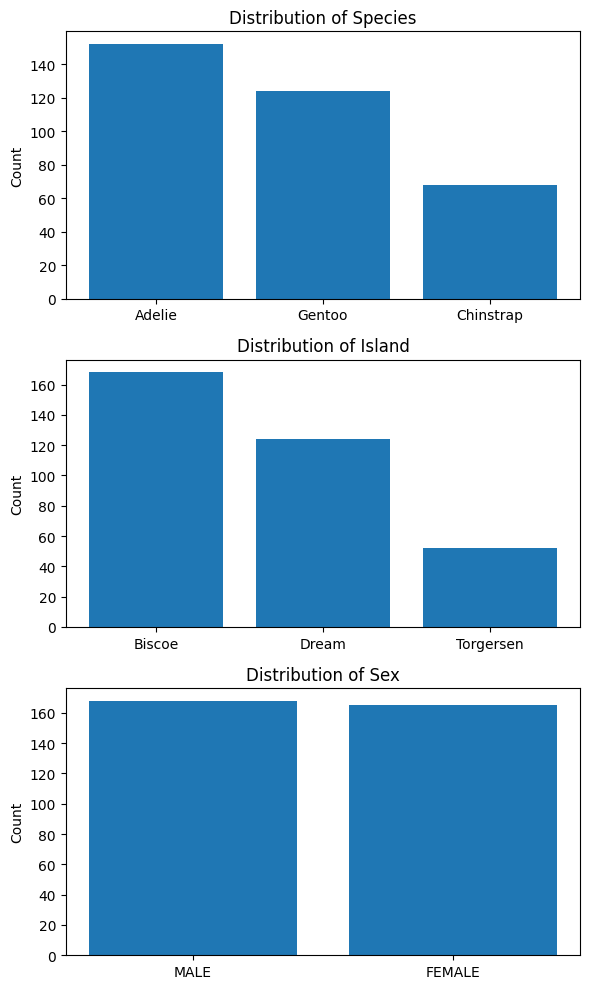

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()

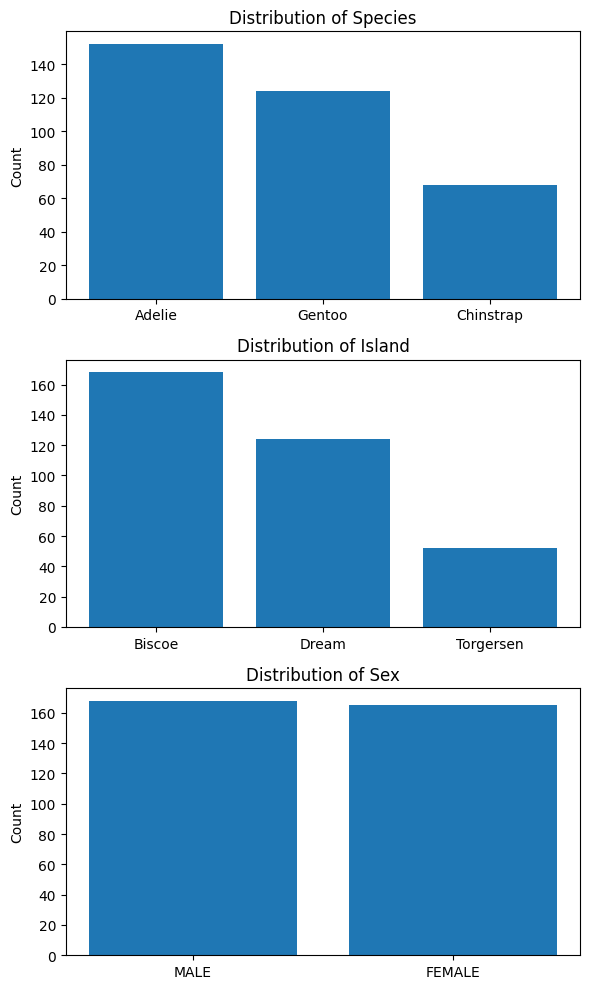

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()

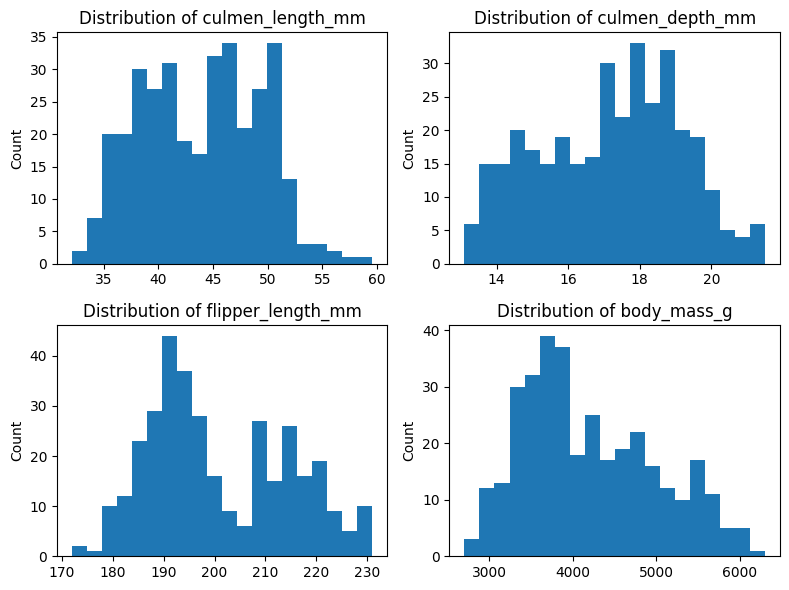

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(penguins["culmen_length_mm"], bins=20)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of culmen_length_mm")

axs[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of culmen_depth_mm")

axs[1, 0].hist(penguins["flipper_length_mm"], bins=20)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of flipper_length_mm")

axs[1, 1].hist(penguins["body_mass_g"], bins=20)
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Distribution of body_mass_g")

plt.tight_layout()
plt.show()

In [20]:
penguins.cov(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


In [21]:
penguins.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


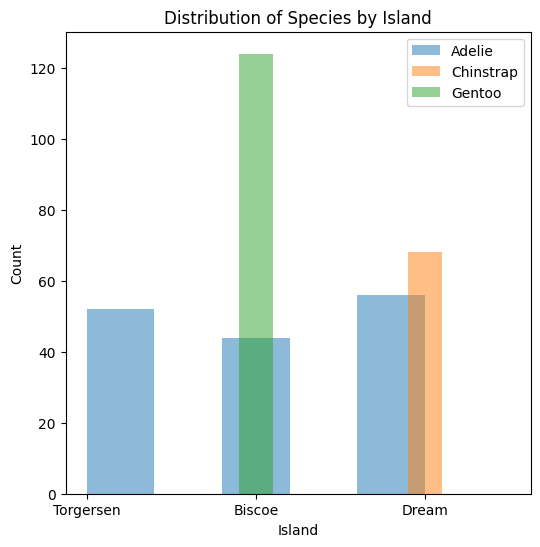

In [22]:
unique_species = penguins["species"].unique()

fig, ax = plt.subplots(figsize=(6, 6))
for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["island"], bins=5, alpha=0.5, label=species)

ax.set_xlabel("Island")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Island")
ax.legend()
plt.show()

## Transforming the Data

### Preprocessing Script

In [23]:
(CODE_FOLDER / "processing").mkdir(parents=True, exist_ok=True)

In [24]:
%%writefile {CODE_FOLDER}/processing/script.py
# | filename: script.py
# | code-line-numbers: true

import os
import tarfile
import tempfile
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


def preprocess(base_directory):
    """Load the supplied data, split it and transform it."""
    df = _read_data_from_input_csv_files(base_directory)

    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])],
    )

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler(),
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(),
    )

    features_transformer = ColumnTransformer(
        transformers=[
            (
                "numeric",
                numeric_transformer,
                make_column_selector(dtype_exclude="object"),
            ),
            ("categorical", categorical_transformer, ["island"]),
        ],
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_train_baseline(base_directory, df_train)
    _save_test_baseline(base_directory, df_test)

    y_train = target_transformer.fit_transform(
        np.array(df_train.species.values).reshape(-1, 1),
    )
    y_validation = target_transformer.transform(
        np.array(df_validation.species.values).reshape(-1, 1),
    )
    y_test = target_transformer.transform(
        np.array(df_test.species.values).reshape(-1, 1),
    )

    df_train = df_train.drop("species", axis=1)
    df_validation = df_validation.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    X_train = features_transformer.fit_transform(df_train)  # noqa: N806
    X_validation = features_transformer.transform(df_validation)  # noqa: N806
    X_test = features_transformer.transform(df_test)  # noqa: N806

    _save_splits(
        base_directory,
        X_train,
        y_train,
        X_validation,
        y_validation,
        X_test,
        y_test,
    )
    _save_model(base_directory, target_transformer, features_transformer)


def _read_data_from_input_csv_files(base_directory):
    """Read the data from the input CSV files.

    This function reads every CSV file available and
    concatenates them into a single dataframe.
    """
    input_directory = Path(base_directory) / "input"
    files = list(input_directory.glob("*.csv"))

    if len(files) == 0:
        message = f"The are no CSV files in {input_directory.as_posix()}/"
        raise ValueError(message)

    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)

    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """Split the data into train, validation, and test."""
    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_train_baseline(base_directory, df_train):
    """Save the untransformed training data to disk.

    We will need the training data to compute a baseline to
    determine the quality of the data that the model receives
    when deployed.
    """
    baseline_path = Path(base_directory) / "train-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_train.copy().dropna()

    # To compute the data quality baseline, we don't need the
    # target variable, so we'll drop it from the dataframe.
    df = df.drop("species", axis=1)

    df.to_csv(baseline_path / "train-baseline.csv", header=True, index=False)


def _save_test_baseline(base_directory, df_test):
    """Save the untransformed test data to disk.

    We will need the test data to compute a baseline to
    determine the quality of the model predictions when deployed.
    """
    baseline_path = Path(base_directory) / "test-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_test.copy().dropna()

    # We'll use the test baseline to generate predictions later,
    # and we can't have a header line because the model won't be
    # able to make a prediction for it.
    df.to_csv(baseline_path / "test-baseline.csv", header=False, index=False)


def _save_splits(
    base_directory,
    X_train,  # noqa: N803
    y_train,
    X_validation,  # noqa: N803
    y_validation,
    X_test,  # noqa: N803
    y_test,
):
    """Save data splits to disk.

    This function concatenates the transformed features
    and the target variable, and saves each one of the split
    sets to disk.
    """
    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        validation_path / "validation.csv",
        header=False,
        index=False,
    )
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """Save the Scikit-Learn transformation pipelines.

    This function creates a model.tar.gz file that
    contains the two transformation pipelines we built
    to transform the data.
    """
    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, Path(directory) / "target.joblib")
        joblib.dump(features_transformer, Path(directory) / "features.joblib")

        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)

        with tarfile.open(f"{(model_path / 'model.tar.gz').as_posix()}", "w:gz") as tar:
            tar.add(Path(directory) / "target.joblib", arcname="target.joblib")
            tar.add(
                Path(directory) / "features.joblib", arcname="features.joblib",
            )


if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Overwriting code/processing/script.py


In [25]:
%%ipytest -s
# | code-fold: true

import os
import shutil
import tarfile
import tempfile

import pytest
from processing.script import preprocess


@pytest.fixture(autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)
    preprocess(base_directory=directory)

    yield directory

    shutil.rmtree(directory)


def test_preprocess_generates_data_splits(directory):
    output_directories = os.listdir(directory)

    assert "train" in output_directories
    assert "validation" in output_directories
    assert "test" in output_directories


def test_preprocess_generates_baselines(directory):
    output_directories = os.listdir(directory)

    assert "train-baseline" in output_directories
    assert "test-baseline" in output_directories


def test_preprocess_creates_two_models(directory):
    model_path = directory / "model"
    tar = tarfile.open(model_path / "model.tar.gz", "r:gz")

    assert "features.joblib" in tar.getnames()
    assert "target.joblib" in tar.getnames()


def test_splits_are_transformed(directory):
    train = pd.read_csv(directory / "train" / "train.csv", header=None)
    validation = pd.read_csv(directory / "validation" / "validation.csv", header=None)
    test = pd.read_csv(directory / "test" / "test.csv", header=None)

    # After transforming the data, the number of features should be 7:
    # * 3 - island (one-hot encoded)
    # * 1 - culmen_length_mm = 1
    # * 1 - culmen_depth_mm
    # * 1 - flipper_length_mm
    # * 1 - body_mass_g
    number_of_features = 7

    # The transformed splits should have an additional column for the target
    # variable.
    assert train.shape[1] == number_of_features + 1
    assert validation.shape[1] == number_of_features + 1
    assert test.shape[1] == number_of_features + 1


def test_train_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "train-baseline" / "train-baseline.csv",
        header=None,
    )

    island = baseline.iloc[:, 0].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_test_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "test-baseline" / "test-baseline.csv", header=None
    )

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_train_baseline_includes_header(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv")
    assert baseline.columns[0] == "island"


def test_test_baseline_does_not_include_header(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv")
    assert baseline.columns[0] != "island"

........
8 passed in 0.43s


### Caching Configuration

In [26]:
cache_config = CacheConfig(enable_caching=True, expire_after="15d")

### Pipeline Configuration

In [27]:
pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)

### Setting up the Processing Step

In [28]:
processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    # By default, a new account doesn't have access to `ml.m5.xlarge` instances.
    # If you haven't requested a quota increase yet, you can use an
    # `ml.t3.medium` instance type instead. This will work out of the box, but
    # the Processing Job will take significantly longer than it should have.
    # To get access to `ml.m5.xlarge` instances, you can request a quota
    # increase under the Service Quotas section in your AWS account.
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

[01/24/25 19:17:27] INFO     Defaulting to only available Python version: py3                     ]8;id=65608;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=228181;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#608\608]8;;\

In [29]:
preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{(CODE_FOLDER / 'processing' / 'script.py').as_posix()}",
        inputs=[
            ProcessingInput(
                source=dataset_location,
                destination="/opt/ml/processing/input",
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="validation",
                source="/opt/ml/processing/validation",
                destination=f"{S3_LOCATION}/preprocessing/validation",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Creating the Pre Processing Pipeline

In [30]:
preprocessing_pipeline = Pipeline(
    name="preprocessing-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

preprocessing_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/preprocessing-pipeline',
 'ResponseMetadata': {'RequestId': '421f4e98-a5a9-4711-b5e8-654c78c85fac',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '421f4e98-a5a9-4711-b5e8-654c78c85fac',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '90',
   'date': 'Sat, 25 Jan 2025 03:17:28 GMT'},
  'RetryAttempts': 0}}

In [31]:
#preprocessing_pipeline.start()

## Training the Model

### Creating the Training Script

In [32]:
(CODE_FOLDER / "training").mkdir(parents=True, exist_ok=True)

In [33]:
%%writefile {CODE_FOLDER}/training/script.py
# | filename: script.py
# | code-line-numbers: true

import argparse
import json
import os
import tarfile

from pathlib import Path
from comet_ml import Experiment

import keras
import numpy as np
import pandas as pd
from keras import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from packaging import version
from sklearn.metrics import accuracy_score


def train(
    model_directory,
    train_path,
    validation_path,
    pipeline_path,
    experiment,
    epochs=50,
    batch_size=32,
):
    print(f"Keras version: {keras.__version__}")

    X_train = pd.read_csv(Path(train_path) / "train.csv")
    y_train = X_train[X_train.columns[-1]]
    X_train = X_train.drop(X_train.columns[-1], axis=1)

    X_validation = pd.read_csv(Path(validation_path) / "validation.csv")
    y_validation = X_validation[X_validation.columns[-1]]
    X_validation = X_validation.drop(X_validation.columns[-1], axis=1)

    model = Sequential(
        [
            Input(shape=(X_train.shape[1],)),
            Dense(10, activation="relu"),
            Dense(8, activation="relu"),
            Dense(3, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.fit(
        X_train,
        y_train,
        validation_data=(X_validation, y_validation),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
    )

    predictions = np.argmax(model.predict(X_validation), axis=-1)
    val_accuracy = accuracy_score(y_validation, predictions)
    print(f"Validation accuracy: {val_accuracy}")

    # Starting on version 3, Keras changed the model saving format.
    # Since we are running the training script using two different versions
    # of Keras, we need to check to see which version we are using and save
    # the model accordingly.
    model_filepath = (
        Path(model_directory) / "001"
        if version.parse(keras.__version__) < version.parse("3")
        else Path(model_directory) / "penguins.keras"
    )

    model.save(model_filepath)

    # Let's save the transformation pipelines inside the
    # model directory so they get bundled together.
    with tarfile.open(Path(pipeline_path) / "model.tar.gz", "r:gz") as tar:
        tar.extractall(model_directory)

    if experiment:
        experiment.log_parameters(
            {
                "epochs": epochs,
                "batch_size": batch_size,
            }
        )
        experiment.log_dataset_hash(X_train)
        experiment.log_confusion_matrix(
            y_validation.astype(int), predictions.astype(int)
        )
        experiment.log_model("penguins", model_filepath.as_posix())


if __name__ == "__main__":
    # Any hyperparameters provided by the training job are passed to
    # the entry point as script arguments.
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=32)
    args, _ = parser.parse_known_args()

    # Let's create a Comet experiment to log the metrics and parameters
    # of this training job.
    comet_api_key = os.environ.get("COMET_API_KEY", None)
    comet_project_name = os.environ.get("COMET_PROJECT_NAME", None)

    experiment = (
        Experiment(
            project_name=comet_project_name,
            api_key=comet_api_key,
            auto_metric_logging=True,
            auto_param_logging=True,
            log_code=True,
        )
        if comet_api_key and comet_project_name
        else None
    )

    training_env = json.loads(os.environ.get("SM_TRAINING_ENV", {}))
    job_name = training_env.get("job_name", None) if training_env else None

    # We want to use the SageMaker's training job name as the name
    # of the experiment so we can easily recognize it.
    if job_name and experiment:
        experiment.set_name(job_name)

    train(
        # This is the location where we need to save our model.
        # SageMaker will create a model.tar.gz file with anything
        # inside this directory when the training script finishes.
        model_directory=os.environ["SM_MODEL_DIR"],
        # SageMaker creates one channel for each one of the inputs
        # to the Training Step.
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        validation_path=os.environ["SM_CHANNEL_VALIDATION"],
        pipeline_path=os.environ["SM_CHANNEL_PIPELINE"],
        experiment=experiment,
        epochs=args.epochs,
        batch_size=args.batch_size,
    )

Overwriting code/training/script.py


In [34]:
%%ipytest -s
#| code-fold: true

import os
import shutil
import pytest
import tempfile

from processing.script import preprocess
from training.script import train

@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    train(
        model_directory=directory / "model",
        train_path=directory / "train", 
        validation_path=directory / "validation",
        pipeline_path=directory / "model",
        experiment=None,
        epochs=1
    )
    
    yield directory
    
    shutil.rmtree(directory)


def test_train_bundles_model_assets(directory):
    bundle = os.listdir(directory / "model")
    assert "001" in bundle
    
    assets = os.listdir(directory / "model" / "001")
    assert "saved_model.pb" in assets


def test_train_bundles_transformation_pipelines(directory):
    bundle = os.listdir(directory / "model")
    assert "target.joblib" in bundle
    assert "features.joblib" in bundle


2025-01-24 19:17:49.424075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras version: 2.14.0
8/8 - 1s - loss: 0.9977 - accuracy: 0.3891 - val_loss: 1.0012 - val_accuracy: 0.3333 - 939ms/epoch - 117ms/step
2/2 [==============================] - 0s 3ms/step
Validation accuracy: 0.3333333333333333


[01/24/25 19:17:56] INFO     Assets written to:                                                 ]8;id=909686;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=752378;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmpzm9i5fya/model                    
                             /001/assets                                                                           

.Keras version: 2.14.0
8/8 - 1s - loss: 1.0985 - accuracy: 0.3264 - val_loss: 1.0906 - val_accuracy: 0.3725 - 586ms/epoch - 73ms/step
2/2 [==============================] - 0s 3ms/step
Validation accuracy: 0.37254901960784315


[01/24/25 19:17:57] INFO     Assets written to:                                                 ]8;id=269227;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=480593;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmppu6jtgfy/model                    
                             /001/assets                                                                           

.
2 passed in 3.18s


In [35]:
%%writefile {CODE_FOLDER}/training/requirements.txt
#| label: requirements.txt
#| filename: requirements.txt
#| code-line-numbers: false

comet-ml

Overwriting code/training/requirements.txt


In [36]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    base_job_name="training",
    entry_point="script.py",
    source_dir=f"{(CODE_FOLDER / 'training').as_posix()}",
    # SageMaker will pass these hyperparameters as arguments
    # to the entry point of the training script.
    hyperparameters={
        "epochs": 50,
        "batch_size": 32,
    },
    # SageMaker will create these environment variables on the
    # Training Job instance.
    environment={
        "COMET_API_KEY": COMET_API_KEY,
        "COMET_PROJECT_NAME": COMET_PROJECT_NAME,
    },
    # SageMaker will track these metrics as part of the experiment
    # associated to this pipeline. The metric definitions tells
    # SageMaker how to parse the values from the Training Job logs.
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    disable_profiler=True,
    debugger_hook_config=False,
    sagemaker_session=config["session"],
    role=role,
)

In [37]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


def create_training_step(estimator):
    """Create a SageMaker TrainingStep using the provided estimator."""
    return TrainingStep(
        name="train-model",
        step_args=estimator.fit(
            inputs={
                "train": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "train"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "validation": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "validation"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "pipeline": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "model"
                    ].S3Output.S3Uri,
                    content_type="application/tar+gzip",
                ),
            },
        ),
        cache_config=cache_config,
    )


train_model_step = create_training_step(estimator)

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=500371;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=975268;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Creating the TF Pipeline

In [38]:
training_tf_pipeline = Pipeline(
    name="training-tf-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

training_tf_pipeline.upsert(role_arn=role)

[01/24/25 19:17:58] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=695298;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=279146;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[01/24/25 19:17:59] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=389643;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=512626;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/training-tf-pipeline',
 'ResponseMetadata': {'RequestId': '9fe3fc76-a0b5-472d-9ad7-e304375b36e7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '9fe3fc76-a0b5-472d-9ad7-e304375b36e7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '88',
   'date': 'Sat, 25 Jan 2025 03:17:59 GMT'},
  'RetryAttempts': 0}}

In [39]:
# training_tf_pipeline.start()

## Custom Training Container & ECR Image

### Preparing the Docker Image

In [40]:
import shutil

(CODE_FOLDER / "containers" / "training").mkdir(parents=True, exist_ok=True)
shutil.copy2(
    CODE_FOLDER / "training" / "script.py",
    CODE_FOLDER / "containers" / "training" / "train.py",
)

PosixPath('code/containers/training/train.py')

In [41]:
%%writefile {CODE_FOLDER}/containers/training/requirements.txt
# | filename: requirements.txt
# | code-line-numbers: true

sagemaker-training
packaging
keras
pandas
scikit-learn
comet_ml
jax[cpu]

Overwriting code/containers/training/requirements.txt


In [42]:
%%writefile {CODE_FOLDER}/containers/training/Dockerfile
# | filename: Dockerfile
# | code-line-numbers: true

FROM python:3.10-slim

RUN apt-get -y update && apt-get install -y --no-install-recommends \
    python3 \
    build-essential libssl-dev pkg-config libhdf5-dev

# Let's install the required Python packages from 
# the requirements.txt file.
COPY requirements.txt .
RUN pip install --user --upgrade pip
RUN pip3 install -r requirements.txt

# We are going to be running the training script
# as the entrypoint of this container.
COPY train.py /opt/ml/code/train.py
ENV SAGEMAKER_PROGRAM train.py

# We want to use JAX as the backend for Keras.
ENV KERAS_BACKEND=jax

Overwriting code/containers/training/Dockerfile


### Building the Docker Image

In [43]:
IMAGE_NAME = "keras-custom-training-container"

if not LOCAL_MODE:
    # If we aren't running the code in Local Mode, we need
    # to specify we want to build the Docker image for the
    # linux/amd64 architecture before uploading it to ECR.
    print("Building Docker image for linux/amd64 architecture...")

    !docker build --platform="linux/amd64" -t $IMAGE_NAME \
        $CODE_FOLDER/containers/training/
else:
    # If we are running in Local Mode, we can use the
    # default Docker build command.
    print("Building Docker image for arm64 architecture...")

    !docker build -t $IMAGE_NAME \
        $CODE_FOLDER/containers/training/

Building Docker image for linux/amd64 architecture...
ERROR: Cannot connect to the Docker daemon at unix:///Users/anchit/.docker/run/docker.sock. Is the docker daemon running?


### Pushing Docker Image to ECR

In [47]:
%%bash -s "$LOCAL_MODE" "$IMAGE_NAME"
# | eval: false

algorithm_name=$2
account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration
# (default to us-east-1 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

repository="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# We only want to push the Docker image to ECR if
# we are not running in Local Mode.
if [ $1 = "False" ]
then
    # Create the repository if it doesn't exist in ECR
    aws ecr describe-repositories \
        --repository-names "${algorithm_name}" > /dev/null 2>&1
    if [ $? -ne 0 ]
    then
        aws ecr create-repository \
            --repository-name "${algorithm_name}" > /dev/null
    fi

    # Get the login command from ECR to run the
    # Docker push command.
    aws ecr get-login-password \
        --region ${region}|docker \
        login --username AWS --password-stdin ${repository}

    # Push the Docker image to the ECR repository
    docker tag ${algorithm_name} ${repository}
    docker push ${repository}
fi

### Setting up the Training Step

In [51]:
account_id = boto3.client("sts").get_caller_identity().get("Account")
tag = ":latest"

uri_suffix = "amazonaws.com"
if region in ["cn-north-1", "cn-northwest-1"]:
    uri_suffix = "amazonaws.com.cn"

training_container_image = (
    IMAGE_NAME
    if LOCAL_MODE
    else (f"{account_id}.dkr.ecr.{region}.amazonaws.com/{IMAGE_NAME}:latest")
)

training_container_image

'418272792030.dkr.ecr.us-west-2.amazonaws.com/keras-custom-training-container:latest'

In [52]:
from sagemaker.estimator import Estimator

keras_estimator = Estimator(
    image_uri=training_container_image,
    instance_count=1,
    instance_type=config["instance_type"],
    sagemaker_session=config["session"],
    role=role,
)

keras_train_model_step = create_training_step(keras_estimator)

[01/24/25 19:23:22] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=559602;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=713660;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Creating the Custom Pipeline

In [53]:
custom_pipeline = Pipeline(
    name="custom-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        # This time we want to use the new training step
        # we created using the custom Docker image.
        keras_train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

custom_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/custom-pipeline',
 'ResponseMetadata': {'RequestId': '9c23892c-a0cc-4d43-8337-107bb5d9fad8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '9c23892c-a0cc-4d43-8337-107bb5d9fad8',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '83',
   'date': 'Sat, 25 Jan 2025 03:23:25 GMT'},
  'RetryAttempts': 0}}

In [54]:
# custom_pipeline.start()

## Tuning the Model

In [55]:
USE_TUNING_STEP = False

### Setting up a Tuning Step

In [56]:
from sagemaker.parameter import IntegerParameter
from sagemaker.tuner import HyperparameterTuner

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="val_accuracy",
    objective_type="Maximize",
    hyperparameter_ranges={
        "epochs": IntegerParameter(10, 50),
    },
    metric_definitions=[{"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}],
    max_jobs=9,
    max_parallel_jobs=3,
)

In [57]:
from sagemaker.workflow.steps import TuningStep

tune_model_step = TuningStep(
    name="tune-model",
    step_args=tuner.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "validation": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "pipeline": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "model"
                ].S3Output.S3Uri,
                content_type="application/tar+gzip",
            ),
        },
    ),
    cache_config=cache_config,
)

### Creating the Pipeline

In [58]:
tuning_pipeline = Pipeline(
    name="tuning-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

tuning_pipeline.upsert(role_arn=role)

[01/24/25 19:23:29] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=690869;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=460641;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[01/24/25 19:23:30] WARNING  No finished training job found associated with this estimator.       ]8;id=366813;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=323843;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=73275;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=333286;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=880800;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=817289;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=201266;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=185278;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    WARNING  No finished training job found associated with this estimator.       ]8;id=983559;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=679519;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=357922;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=861013;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=204169;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=712522;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/tuning-pipeline',
 'ResponseMetadata': {'RequestId': '8bb5a360-121b-4e5d-9677-e1162c372859',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8bb5a360-121b-4e5d-9677-e1162c372859',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '83',
   'date': 'Sat, 25 Jan 2025 03:23:31 GMT'},
  'RetryAttempts': 0}}

In [59]:
# tuning_pipeline.start()

## Evaluating the Model

### Creating the Evaluation Script

In [60]:
(CODE_FOLDER / "evaluation").mkdir(parents=True, exist_ok=True)

In [61]:
%%writefile {CODE_FOLDER}/evaluation/script.py
# | filename: script.py
# | code-line-numbers: true

import json
import tarfile
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow import keras


def evaluate(model_path, test_path, output_path):
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test = X_test.drop(X_test.columns[-1], axis=1)

    # Let's now extract the model package so we can load
    # it in memory.
    with tarfile.open(Path(model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(model_path))

    model = keras.models.load_model(Path(model_path) / "001")

    predictions = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test accuracy: {accuracy}")

    # Let's create an evaluation report using the model accuracy.
    evaluation_report = {
        "metrics": {
            "accuracy": {"value": accuracy},
        },
    }

    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "evaluation.json", "w") as f:
        f.write(json.dumps(evaluation_report))


if __name__ == "__main__":
    evaluate(
        model_path="/opt/ml/processing/model/",
        test_path="/opt/ml/processing/test/",
        output_path="/opt/ml/processing/evaluation/",
    )

Overwriting code/evaluation/script.py


In [62]:
%%ipytest -s
# | code-fold: true

import os
import shutil
import tarfile
import pytest
import tempfile

from processing.script import preprocess
from training.script import train
from evaluation.script import evaluate


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)

    preprocess(base_directory=directory)

    train(
        model_directory=directory / "model",
        train_path=directory / "train",
        validation_path=directory / "validation",
        pipeline_path=directory / "model",
        experiment=None,
        epochs=1,
    )

    # After training a model, we need to prepare a package just like
    # SageMaker would. This package is what the evaluation script is
    # expecting as an input.
    with tarfile.open(directory / "model.tar.gz", "w:gz") as tar:
        tar.add(directory / "model" / "001", arcname="001")

    evaluate(
        model_path=directory,
        test_path=directory / "test",
        output_path=directory / "evaluation",
    )

    yield directory / "evaluation"

    shutil.rmtree(directory)


def test_evaluate_generates_evaluation_report(directory):
    output = os.listdir(directory)
    assert "evaluation.json" in output


def test_evaluation_report_contains_accuracy(directory):
    with open(directory / "evaluation.json", "r") as file:
        report = json.load(file)

    assert "metrics" in report
    assert "accuracy" in report["metrics"]

Keras version: 2.14.0
8/8 - 1s - loss: 1.1081 - accuracy: 0.3556 - val_loss: 1.0889 - val_accuracy: 0.4510 - 578ms/epoch - 72ms/step
2/2 [==============================] - 0s 2ms/step
Validation accuracy: 0.45098039215686275


[01/24/25 19:23:35] INFO     Assets written to:                                                 ]8;id=12312;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=955634;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmpz3inrp46/model                    
                             /001/assets                                                                           

2/2 [==============================] - 0s 2ms/step
Test accuracy: 0.5098039215686274
.Keras version: 2.14.0
8/8 - 1s - loss: 0.9668 - accuracy: 0.4268 - val_loss: 0.9442 - val_accuracy: 0.4510 - 521ms/epoch - 65ms/step


[01/24/25 19:23:37] WARNING  5 out of the last 9 calls to <function                     ]8;id=909445;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=887079;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#156\156]8;;\
                             Model.make_predict_function.<locals>.predict_function at                              
                             0x13e601120> triggered tf.function retracing. Tracing is                              
                             expensive and the excessive number of tracings could be                               
                             due to (1) creating @tf.function repeatedly in a loop, (2)                            
                             passing tensors with different shapes, (3) passing Python                             
                             objects instead of tensors. For (1), please define your                               
                             @tf.function outside of the loop. For (2), @tf.function                               
                             has reduce_retracing=True option that can avoid                                       
                             unnecessary retracing. For (3), please refer to                                       
                             https://www.tensorflow.org/guide/function#controlling_retr                            
                             acing and                                                                             
                             https://www.tensorflow.org/api_docs/python/tf/function for                            
                             more details.                                                                         

2/2 [==============================] - 0s 4ms/step
Validation accuracy: 0.45098039215686275


[01/24/25 19:23:38] INFO     Assets written to:                                                 ]8;id=117712;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=207543;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmp0_lsnw67/model                    
                             /001/assets                                                                           

                    WARNING  6 out of the last 11 calls to <function                    ]8;id=449810;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=237153;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#156\156]8;;\
                             Model.make_predict_function.<locals>.predict_function at                              
                             0x13d868430> triggered tf.function retracing. Tracing is                              
                             expensive and the excessive number of tracings could be                               
                             due to (1) creating @tf.function repeatedly in a loop, (2)                            
                             passing tensors with different shapes, (3) passing Python                             
                             objects instead of tensors. For (1), please define your                               
                             @tf.function outside of the loop. For (2), @tf.function                               
                             has reduce_retracing=True option that can avoid                                       
                             unnecessary retracing. For (3), please refer to                                       
                             https://www.tensorflow.org/guide/function#controlling_retr                            
                             acing and                                                                             
                             https://www.tensorflow.org/api_docs/python/tf/function for                            
                             more details.                                                                         

2/2 [==============================] - 0s 2ms/step
Test accuracy: 0.5294117647058824
.
2 passed in 4.41s


### Referencing the Model Assets and Mapping the Output to a Property File

In [63]:
model_assets = train_model_step.properties.ModelArtifacts.S3ModelArtifacts

if USE_TUNING_STEP:
    model_assets = tune_model_step.get_top_model_s3_uri(
        top_k=0,
        s3_bucket=config["session"].default_bucket(),
    )

In [64]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="evaluation-report",
    output_name="evaluation",
    path="evaluation.json",
)

### Setting up the Evaluation Step

In [65]:
from sagemaker.tensorflow import TensorFlowProcessor

evaluation_processor = TensorFlowProcessor(
    base_job_name="evaluation-processor",
    image_uri=config["image"],
    framework_version=config["framework_version"],
    py_version=config["py_version"],
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

[01/24/25 19:23:43] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=463512;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=281160;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

In [66]:
evaluate_model_step = ProcessingStep(
    name="evaluate-model",
    step_args=evaluation_processor.run(
        code=f"{(CODE_FOLDER / 'evaluation' / 'script.py').as_posix()}",
        inputs=[
            # The first input is the test split that we generated on
            # the first step of the pipeline when we split and
            # transformed the data.
            ProcessingInput(
                source=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test",
            ),
            # The second input is the model that we generated on
            # the Training or Tunning Step.
            ProcessingInput(
                source=model_assets,
                destination="/opt/ml/processing/model",
            ),
        ],
        outputs=[
            # The output is the evaluation report that we generated
            # in the evaluation script.
            ProcessingOutput(
                output_name="evaluation",
                source="/opt/ml/processing/evaluation",
            ),
        ],
    ),
    property_files=[evaluation_report],
    cache_config=cache_config,
    
)

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Creating the Pipeline

In [67]:
eval_pipeline = Pipeline(
    name="eval-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

eval_pipeline.upsert(role_arn=role)

[01/24/25 19:23:45] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=801278;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=353494;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Uploaded None to                                                    ]8;id=158177;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=177202;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/eval-pipeline/code/5693d7f038291da90851141a1b8                   
                             541f64517f1afae7bd6e3427b7d1198900293/sourcedir.tar.gz                                

                    INFO     runproc.sh uploaded to                                              ]8;id=892291;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=62603;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/eval-pipeline/code/a4bba461eebaa0fe5416b6a2d35                   
                             47f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                                      

[01/24/25 19:23:46] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=701828;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=566767;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Uploaded None to                                                    ]8;id=348845;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=725233;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/eval-pipeline/code/5693d7f038291da90851141a1b8                   
                             541f64517f1afae7bd6e3427b7d1198900293/sourcedir.tar.gz                                

                    INFO     runproc.sh uploaded to                                              ]8;id=204056;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=184949;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/eval-pipeline/code/a4bba461eebaa0fe5416b6a2d35                   
                             47f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                                      

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/eval-pipeline',
 'ResponseMetadata': {'RequestId': '9419a7ce-3215-4639-91cb-32d51ba0858b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '9419a7ce-3215-4639-91cb-32d51ba0858b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '81',
   'date': 'Sat, 25 Jan 2025 03:23:46 GMT'},
  'RetryAttempts': 0}}

In [68]:
# eval_pipeline.start()

## Registering the Model

### Configuring the Model Package Group

In [69]:
BASIC_MODEL_PACKAGE_GROUP = "basic-penguins"

### Creating the Model

In [70]:
from sagemaker.tensorflow.model import TensorFlowModel

tensorflow_model = TensorFlowModel(
    model_data=model_assets,
    framework_version=config["framework_version"],
    sagemaker_session=config["session"],
    role=role,
)

### Configuring Model Metrics

In [71]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.functions import Join

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=Join(
            on="/",
            values=[
                evaluate_model_step.properties.ProcessingOutputConfig.Outputs[
                    "evaluation"
                ].S3Output.S3Uri,
                "evaluation.json",
            ],
        ),
        content_type="application/json",
    ),
)

### Registering the Model

In [72]:
from sagemaker.workflow.model_step import ModelStep


def create_registration_step(
    model,
    model_package_group_name,
    approval_status="Approved",
    content_types=["text/csv"],
    response_types=["application/json"],
    model_metrics=None,
    drift_check_baselines=None,
):
    """Create a Registration Step using the supplied parameters."""
    return ModelStep(
        name="register",
        step_args=model.register(
            model_package_group_name=model_package_group_name,
            approval_status=approval_status,
            model_metrics=model_metrics,
            drift_check_baselines=drift_check_baselines,
            content_types=content_types,
            response_types=response_types,
            inference_instances=[config["instance_type"]],
            transform_instances=[config["instance_type"]],
            framework_version=config["framework_version"],
            domain="MACHINE_LEARNING",
            task="CLASSIFICATION",
            framework="TENSORFLOW",
        ),
    )


register_model_step = create_registration_step(
    tensorflow_model,
    BASIC_MODEL_PACKAGE_GROUP,
    model_metrics=model_metrics,
)

[01/24/25 19:23:52] INFO     image_uri is not presented, retrieving image_uri based on instance_type,  ]8;id=665411;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/tensorflow/model.py\model.py]8;;\:]8;id=466841;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/tensorflow/model.py#508\508]8;;\
                             framework etc.                                                                        

### Creating the Pipeline

In [73]:
model_reg_pipeline = Pipeline(
    name="model-reg-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        register_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

model_reg_pipeline.upsert(role_arn=role)

[01/24/25 19:23:54] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=799627;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=844280;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Uploaded None to                                                    ]8;id=465915;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=464888;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/model-reg-pipeline/code/5693d7f038291da9085114                   
                             1a1b8541f64517f1afae7bd6e3427b7d1198900293/sourcedir.tar.gz                           

                    INFO     runproc.sh uploaded to                                              ]8;id=224664;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=684456;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/model-reg-pipeline/code/a4bba461eebaa0fe5416b6                   
                             a2d3547f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                                 

                    WARNING  Popping out 'CertifyForMarketplace' from the pipeline definition since   ]8;id=615310;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/_utils.py\_utils.py]8;;\:]8;id=504851;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/_utils.py#515\515]8;;\
                             it will be overridden in pipeline execution time.                                     

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=146706;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=277623;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Uploaded None to                                                    ]8;id=903240;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=654712;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/model-reg-pipeline/code/5693d7f038291da9085114                   
                             1a1b8541f64517f1afae7bd6e3427b7d1198900293/sourcedir.tar.gz                           

                    INFO     runproc.sh uploaded to                                              ]8;id=263091;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=375249;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/model-reg-pipeline/code/a4bba461eebaa0fe5416b6                   
                             a2d3547f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                                 

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/model-reg-pipeline',
 'ResponseMetadata': {'RequestId': 'a34cc1db-aad7-4c9e-95b1-335771767343',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a34cc1db-aad7-4c9e-95b1-335771767343',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '86',
   'date': 'Sat, 25 Jan 2025 03:23:55 GMT'},
  'RetryAttempts': 0}}

In [74]:
# model_reg_pipeline.start()

## Deploying From the Pipeline

### Configuring Data Capture Settings

In [75]:
from sagemaker.workflow.parameters import ParameterFloat

accuracy_threshold = ParameterFloat(name="accuracy_threshold", default_value=0.70)

### Setting up a Fail Step

In [76]:
from sagemaker.workflow.fail_step import FailStep

fail_step = FailStep(
    name="fail",
    error_message=Join(
        on=" ",
        values=[
            "Execution failed because the model's accuracy was lower than",
            accuracy_threshold,
        ],
    ),
)

### Defining the Condition

In [77]:
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.functions import JsonGet

condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value",
    ),
    right=accuracy_threshold,
)

### Setting up the Condition Step

In [78]:
from sagemaker.workflow.condition_step import ConditionStep

condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step],
    else_steps=[fail_step],
)

### Creating the Pipeline

In [79]:
model_reg_cond_pipeline = Pipeline(
    name="model-reg-cond-pipeline-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

model_reg_cond_pipeline.upsert(role_arn=role)

[01/24/25 19:24:05] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=308817;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=808954;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Uploaded None to                                                    ]8;id=137644;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=322548;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/model-reg-cond-pipeline-pipeline/code/5693d7f0                   
                             38291da90851141a1b8541f64517f1afae7bd6e3427b7d1198900293/sourcedir.                   
                             tar.gz                                                                                

[01/24/25 19:24:06] INFO     runproc.sh uploaded to                                              ]8;id=701981;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=971349;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/model-reg-cond-pipeline-pipeline/code/a4bba461                   
                             eebaa0fe5416b6a2d3547f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                   

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/model-reg-cond-pipeline-pipeline',
 'ResponseMetadata': {'RequestId': 'ed141661-47c5-438d-ab55-0c303e1321d7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ed141661-47c5-438d-ab55-0c303e1321d7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '100',
   'date': 'Sat, 25 Jan 2025 03:24:06 GMT'},
  'RetryAttempts': 0}}

In [80]:
model_reg_cond_pipeline.start(
    parameters=dict(accuracy_threshold = 0.95)
)

_PipelineExecution(arn='arn:aws:sagemaker:us-west-2:418272792030:pipeline/model-reg-cond-pipeline-pipeline/execution/pjg5bs6vqfgw', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x10c2064a0>)

## Serving the Model with Baisc Flask APP

### Retrieving List of Approved Models


In [81]:
response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=BASIC_MODEL_PACKAGE_GROUP,
    ModelApprovalStatus="Approved",
    SortBy="CreationTime",
    MaxResults=1,
)

package = (
    response["ModelPackageSummaryList"][0]
    if response["ModelPackageSummaryList"]
    else None
)

package

{'ModelPackageGroupName': 'basic-penguins',
 'ModelPackageVersion': 1,
 'ModelPackageArn': 'arn:aws:sagemaker:us-west-2:418272792030:model-package/basic-penguins/1',
 'CreationTime': datetime.datetime(2025, 1, 23, 19, 25, 21, 279000, tzinfo=tzlocal()),
 'ModelPackageStatus': 'Completed',
 'ModelApprovalStatus': 'Approved'}

### Downloading the Model

In [82]:
(CODE_FOLDER / "serving").mkdir(parents=True, exist_ok=True)

In [90]:
from sagemaker.s3 import S3Downloader

if package:
    response = sagemaker_client.describe_model_package(
        ModelPackageName=package["ModelPackageArn"],
    )

    model_data = response["InferenceSpecification"]["Containers"][0]["ModelDataUrl"]
    S3Downloader.download(model_data, (CODE_FOLDER / "serving").as_posix())

[01/30/25 16:49:38] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=771788;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=939244;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

### Creating the Serving Script

In [91]:
%%writefile {CODE_FOLDER}/serving/app.py
# | filename: app.py
# | code-line-numbers: true

import tarfile
import tempfile
import numpy as np

from flask import Flask, request, jsonify
from pathlib import Path
from tensorflow import keras


MODEL_PATH = Path(__file__).parent


class Model:
    model = None

    def load(self):
        """
        Extracts the model package and loads the model in memory
        if it hasn't been loaded yet.
        """
        # We want to load the model only if it is not loaded yet.
        if not Model.model:
            # Before we load the model, we need to extract it in
            # a temporal directory.

            with tempfile.TemporaryDirectory() as directory:
                with tarfile.open(MODEL_PATH / "model.tar.gz") as tar:
                    tar.extractall(path=directory)

                Model.model = keras.models.load_model(Path(directory) / "001")

    def predict(self, data):
        """
        Generates predictions for the supplied data.
        """
        self.load()
        return Model.model.predict(data)


app = Flask(__name__)
model = Model()


@app.route("/predict/", methods=["POST"])
def predict():
    data = request.data.decode("utf-8")

    data = np.array(data.split(",")).astype(np.float32)
    data = np.expand_dims(data, axis=0)

    predictions = model.predict(data=[data])

    prediction = int(np.argmax(predictions[0], axis=-1))
    confidence = float(predictions[0][prediction])

    return jsonify({"prediction": prediction, "confidence": confidence})

Writing code/serving/app.py


### Running the Flask Application

```bash
$ flask --app program/code/serving/app.py --debug run --host=0.0.0.0 --port=4242
```

After the server is running, you can send a POST request to the server to get a prediction. Here is an example using the `curl` command:

```bash
$ curl --location --request POST 'http://localhost:4242/predict' \
    --header 'Content-Type: text/plain' \
    --data-raw '0.6569590202313976, -1.0813829646495108, 1.2097102831892812, 0.9226343641317372, 1.0, 0.0, 0.0'
```

## Deploying the Model

### Configuring the Endpoint Name

In [93]:
from sagemaker.predictor import Predictor

ENDPOINT = "penguins-endpoint"

### Creating a Model Package

In [95]:
from sagemaker import ModelPackage

if package:
    model_package = ModelPackage(
        model_package_arn=package["ModelPackageArn"],
        sagemaker_session=sagemaker_session,
        role=role,
    )

    print(package["ModelPackageArn"])

arn:aws:sagemaker:us-west-2:418272792030:model-package/basic-penguins/1


### Deploying the Model

In [96]:
%%script false --no-raise-error
# | eval: false

model_package.deploy(
    endpoint_name=ENDPOINT,
    initial_instance_count=1,
    instance_type=config["instance_type"],
)

[01/30/25 17:00:18] INFO     Creating model with name: basic-penguins-2025-01-31-01-00-17-821       ]8;id=327626;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=978574;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[01/30/25 17:00:23] INFO     Creating endpoint-config with name penguins-endpoint                   ]8;id=463131;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=583729;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

                    INFO     Creating endpoint with name penguins-endpoint                          ]8;id=106828;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=837866;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

-----!

### Testing the Endpoint

In [97]:
payload = """
0.6569590202313976,-1.0813829646495108,1.2097102831892812,0.9226343641317372,1.0,0.0,0.0
-0.7751048801481084,0.8822689351285553,-1.2168066120762704,0.9226343641317372,0.0,1.0,0.0
-0.837387834894918,0.3386660813829646,-0.26237731892812,-1.92351941317372,0.0,0.0,1.0
"""

In [98]:
predictor = Predictor(endpoint_name=ENDPOINT)

try:
    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))

    print(json.dumps(response, indent=2))
    print(f"\nSpecies: {np.argmax(response['predictions'], axis=1)}")
except Exception as e:
    print(e)

{
  "predictions": [
    [
      0.109435402,
      0.0212360118,
      0.869328618
    ],
    [
      0.462303758,
      0.237504542,
      0.30019173
    ],
    [
      0.474932,
      0.3007029,
      0.2243651
    ]
  ]
}

Species: [2 0 0]


In [99]:
try:
    sagemaker_client.delete_endpoint(EndpointName=ENDPOINT)
except Exception as e:
    print(e)

## Deploying From the Pipeline

### Configuring Data Capture Settings

In [100]:
DATA_CAPTURE_PERCENTAGE = 100
DATA_CAPTURE_DESTINATION = f"{S3_LOCATION}/monitoring/data-capture"

### Setting up the Lambda Function

In [101]:
(CODE_FOLDER / "lambda").mkdir(parents=True, exist_ok=True)

In [102]:
%%writefile {CODE_FOLDER}/lambda/lambda.py
# | filename: lambda.py
# | code-line-numbers: true

import os
import json
import boto3
import time

sagemaker = boto3.client("sagemaker")


def lambda_handler(event, context):
    # If we are calling this function from EventBridge,
    # we need to extract the model package ARN and the
    # approval status from the event details. If we are
    # calling this function from the pipeline, we can
    # assume the model is approved and we can get the
    # model package ARN as a direct parameter.
    if "detail" in event:
        model_package_arn = event["detail"]["ModelPackageArn"]
        approval_status = event["detail"]["ModelApprovalStatus"]
    else:
        model_package_arn = event["model_package_arn"]
        approval_status = "Approved"

    print(f"Model: {model_package_arn}")
    print(f"Approval status: {approval_status}")

    if approval_status != "Approved":
        response = {
            "message": "Skipping deployment.",
            "approval_status": approval_status,
        }

        print(response)
        return {"statusCode": 200, "body": json.dumps(response)}

    endpoint_name = os.environ["ENDPOINT"]
    data_capture_percentage = int(os.environ["DATA_CAPTURE_PERCENTAGE"])
    data_capture_destination = os.environ["DATA_CAPTURE_DESTINATION"]
    role = os.environ["ROLE"]

    timestamp = time.strftime("%m%d%H%M%S", time.localtime())
    model_name = f"{endpoint_name}-model-{timestamp}"
    endpoint_config_name = f"{endpoint_name}-config-{timestamp}"

    sagemaker.create_model(
        ModelName=model_name,
        ExecutionRoleArn=role,
        Containers=[{"ModelPackageName": model_package_arn}],
    )

    sagemaker.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "ModelName": model_name,
                "InstanceType": "ml.m5.xlarge",
                "InitialVariantWeight": 1,
                "InitialInstanceCount": 1,
                "VariantName": "AllTraffic",
            }
        ],
        # We can enable Data Capture to record the inputs and outputs
        # of the endpoint to use them later for monitoring the model.
        DataCaptureConfig={
            "EnableCapture": True,
            "InitialSamplingPercentage": data_capture_percentage,
            "DestinationS3Uri": data_capture_destination,
            "CaptureOptions": [
                {"CaptureMode": "Input"},
                {"CaptureMode": "Output"},
            ],
            "CaptureContentTypeHeader": {
                "CsvContentTypes": ["text/csv", "application/octect-stream"],
                "JsonContentTypes": ["application/json", "application/octect-stream"],
            },
        },
    )

    response = sagemaker.list_endpoints(NameContains=endpoint_name, MaxResults=1)

    if len(response["Endpoints"]) == 0:
        # If the endpoint doesn't exist, let's create it.
        sagemaker.create_endpoint(
            EndpointName=endpoint_name,
            EndpointConfigName=endpoint_config_name,
        )
    else:
        # If the endpoint already exists, let's update it with the
        # new configuration.
        sagemaker.update_endpoint(
            EndpointName=endpoint_name,
            EndpointConfigName=endpoint_config_name,
        )

    return {"statusCode": 200, "body": json.dumps("Endpoint deployed successfully")}

Writing code/lambda/lambda.py


### Setting up Lambda Permissions

In [103]:
lambda_role_name = "lambda-deployment-role"
lambda_role_arn = None

try:
    response = iam_client.create_role(
        RoleName=lambda_role_name,
        AssumeRolePolicyDocument=json.dumps(
            {
                "Version": "2012-10-17",
                "Statement": [
                    {
                        "Effect": "Allow",
                        "Principal": {
                            "Service": ["lambda.amazonaws.com", "events.amazonaws.com"],
                        },
                        "Action": "sts:AssumeRole",
                    },
                ],
            },
        ),
        Description="Lambda Endpoint Deployment",
    )

    lambda_role_arn = response["Role"]["Arn"]

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
        RoleName=lambda_role_name,
    )

    iam_client.attach_role_policy(
        PolicyArn="arn:aws:iam::aws:policy/AmazonSageMakerFullAccess",
        RoleName=lambda_role_name,
    )

    print(f'Role "{lambda_role_name}" created with ARN "{lambda_role_arn}".')
except iam_client.exceptions.EntityAlreadyExistsException:
    response = iam_client.get_role(RoleName=lambda_role_name)
    lambda_role_arn = response["Role"]["Arn"]
    print(f'Role "{lambda_role_name}" already exists with ARN "{lambda_role_arn}".')

Role "lambda-deployment-role" created with ARN "arn:aws:iam::418272792030:role/lambda-deployment-role".


### Creating the Lambda Function

In [104]:
from sagemaker.lambda_helper import Lambda

deploy_lambda_fn = Lambda(
    function_name="deployment_fn",
    execution_role_arn=lambda_role_arn,
    script=(CODE_FOLDER / "lambda" / "lambda.py").as_posix(),
    handler="lambda.lambda_handler",
    timeout=600,
    session=sagemaker_session,
    runtime="python3.11",
    environment={
        "Variables": {
            "ENDPOINT": ENDPOINT,
            "DATA_CAPTURE_DESTINATION": DATA_CAPTURE_DESTINATION,
            "DATA_CAPTURE_PERCENTAGE": str(DATA_CAPTURE_PERCENTAGE),
            "ROLE": role,
        },
    },
)

deploy_lambda_fn_response = deploy_lambda_fn.upsert()
deploy_lambda_fn_response

{'ResponseMetadata': {'RequestId': '496750de-38b2-4c07-b834-31c9924fd451',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Fri, 31 Jan 2025 01:09:49 GMT',
   'content-type': 'application/json',
   'content-length': '1593',
   'connection': 'keep-alive',
   'x-amzn-requestid': '496750de-38b2-4c07-b834-31c9924fd451'},
  'RetryAttempts': 0},
 'FunctionName': 'deployment_fn',
 'FunctionArn': 'arn:aws:lambda:us-west-2:418272792030:function:deployment_fn',
 'Runtime': 'python3.11',
 'Role': 'arn:aws:iam::418272792030:role/lambda-deployment-role',
 'Handler': 'lambda.lambda_handler',
 'CodeSize': 3498,
 'Description': '',
 'Timeout': 600,
 'MemorySize': 128,
 'LastModified': '2025-01-31T01:09:48.987+0000',
 'CodeSha256': 'hfygWIKtUV2Ec8y2uGKyUQ/HvBcXWO7vm5QvwjF8g70=',
 'Version': '$LATEST',
 'Environment': {'Variables': {'ROLE': 'arn:aws:iam::418272792030:role/service-role/AmazonSageMaker-ExecutionRole-20240811T215140',
   'DATA_CAPTURE_PERCENTAGE': '100',
   'DATA_CAPTURE_DESTINATION': '

### Setting up the Lambda Step

In [105]:
from sagemaker.workflow.lambda_step import LambdaStep


def create_deployment_step(register_model_step):
    """Create a Deploy Step using the supplied parameters."""
    return LambdaStep(
        name="deploy",
        lambda_func=deploy_lambda_fn,
        inputs={
            "model_package_arn": register_model_step.properties.ModelPackageArn,
        },
    )


deploy_step = create_deployment_step(register_model_step)

### Modifying the Condition Step

In [106]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step, deploy_step],
    else_steps=[fail_step],
)

### Creating the Pipeline

In [109]:
lambda_pipeline = Pipeline(
    name="lambda-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

lambda_pipeline.upsert(role_arn=role)

[01/30/25 17:12:50] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=20037;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=586818;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Uploaded None to                                                    ]8;id=234140;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=577579;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/lambda-pipeline/code/5693d7f038291da90851141a1                   
                             b8541f64517f1afae7bd6e3427b7d1198900293/sourcedir.tar.gz                              

[01/30/25 17:12:51] INFO     runproc.sh uploaded to                                              ]8;id=368007;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=28685;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/lambda-pipeline/code/a4bba461eebaa0fe5416b6a2d                   
                             3547f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                                    

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/lambda-pipeline',
 'ResponseMetadata': {'RequestId': 'c8e171b9-4966-4a0e-9c00-da65f31063b5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c8e171b9-4966-4a0e-9c00-da65f31063b5',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '83',
   'date': 'Fri, 31 Jan 2025 01:12:52 GMT'},
  'RetryAttempts': 0}}

In [110]:
# lambda_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-west-2:418272792030:pipeline/lambda-pipeline/execution/klz4rzpnnvum', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x10c2064a0>)

In [111]:
def wait_for_endpoint():
    """Wait for the endpoint to come in service."""
    waiter = sagemaker_client.get_waiter("endpoint_in_service")
    waiter.wait(EndpointName=ENDPOINT, WaiterConfig={"Delay": 10, "MaxAttempts": 30})


payload = "0.6569590202313976,-1.0813829646495108,1.2097102831892812,0.9226343641317372,1.0,0.0,0.0"  # noqa: E501


try:
    wait_for_endpoint()

    predictor = Predictor(endpoint_name=ENDPOINT)

    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))

    print(json.dumps(response, indent=2))
except Exception as e:
    print(e)

{
  "predictions": [
    [
      0.0510262661,
      0.0543268695,
      0.894646883
    ]
  ]
}


In [112]:
try:
    sagemaker_client.delete_endpoint(EndpointName=ENDPOINT)
except Exception as e:
    print(e)

## Deploying From an Event

### Configuring the Model Package Group

In [114]:
PENDING_MODEL_PACKAGE_GROUP = "pending-penguins"

### Setting Up EventBridge

In [115]:
event_pattern = f"""
{{
  "source": ["aws.sagemaker"],
  "detail-type": ["SageMaker Model Package State Change"],
  "detail": {{
    "ModelPackageGroupName": ["{PENDING_MODEL_PACKAGE_GROUP}"],
    "ModelApprovalStatus": ["Approved"]
  }}
}}
"""

In [116]:
rule_name = "PendingModelApprovedRule"

events_client = boto3.client("events")
rule_response = events_client.put_rule(
    Name=rule_name,
    EventPattern=event_pattern,
    State="ENABLED",
    RoleArn=role,
)

In [117]:
response = events_client.put_targets(
    Rule=rule_name,
    Targets=[
        {
            "Id": "1",
            "Arn": deploy_lambda_fn_response["FunctionArn"],
        },
    ],
)

### Configuring the Lambda Permissions

In [118]:
lambda_function_name = deploy_lambda_fn_response["FunctionName"]
lambda_client = boto3.client("lambda")

try:
    response = lambda_client.add_permission(
        Action="lambda:InvokeFunction",
        FunctionName=lambda_function_name,
        Principal="events.amazonaws.com",
        SourceArn=rule_response["RuleArn"],
        StatementId="EventBridge",
    )
except lambda_client.exceptions.ResourceConflictException:
    print(f'Function "{lambda_function_name}" already has the specified permission.')

### Registering the Model

In [119]:
register_model_step = create_registration_step(
    tensorflow_model,
    PENDING_MODEL_PACKAGE_GROUP,
    approval_status="PendingManualApproval",
    model_metrics=model_metrics,
)

### Modifying the Condition Step

In [120]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step],
    else_steps=[fail_step],
)

### Creating the Pipeline

In [122]:
event_pipeline = Pipeline(
    name="event-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

event_pipeline.upsert(role_arn=role)

[01/31/25 17:21:38] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=681856;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=815764;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Uploaded None to                                                    ]8;id=721375;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=674671;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/event-pipeline/code/5693d7f038291da90851141a1b                   
                             8541f64517f1afae7bd6e3427b7d1198900293/sourcedir.tar.gz                               

                    INFO     runproc.sh uploaded to                                              ]8;id=563289;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=818335;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/event-pipeline/code/a4bba461eebaa0fe5416b6a2d3                   
                             547f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                                     

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/event-pipeline',
 'ResponseMetadata': {'RequestId': '2608a8e9-9c62-4f33-9c9a-eebceb47d1da',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2608a8e9-9c62-4f33-9c9a-eebceb47d1da',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '82',
   'date': 'Sat, 01 Feb 2025 01:21:39 GMT'},
  'RetryAttempts': 0}}

In [123]:
#event_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-west-2:418272792030:pipeline/event-pipeline/execution/g6nnu9blnqro', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x10c2064a0>)

## Building an Inference Pipeline

### Creating the Preprocessing Script

In [124]:
(CODE_FOLDER / "pipeline").mkdir(parents=True, exist_ok=True)

In [125]:
%%writefile {CODE_FOLDER}/pipeline/preprocessing_component.py
#| filename: preprocessing_component.py
#| code-line-numbers: true

import os
import pandas as pd
import json
import joblib

from io import StringIO

try:
    from sagemaker_containers.beta.framework import worker
except ImportError:
    # We don't have access to the `worker` package when testing locally.
    # We'll set it to None so we can change the way functions create
    # a response.
    worker = None


TARGET_COLUMN = "species"
FEATURE_COLUMNS = [
    "island",
    "culmen_length_mm",
    "culmen_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
    "sex",
]


def model_fn(model_dir):
    """
    Deserializes the model that will be used in this container.
    """

    return joblib.load(os.path.join(model_dir, "features.joblib"))


def input_fn(input_data, content_type):
    """
    Parses the input payload and creates a Pandas DataFrame.

    This function will check whether the target column is present in the
    input data and will remove it.
    """

    if content_type == "text/csv":
        df = pd.read_csv(StringIO(input_data), header=None, skipinitialspace=True)

        # If we find an extra column, it's probably the target
        # feature, so let's drop it. We'll assume the target
        # is always the first column,
        if len(df.columns) == len(FEATURE_COLUMNS) + 1:
            df = df.drop(df.columns[0], axis=1)

        df.columns = FEATURE_COLUMNS
        return df

    if content_type == "application/json":
        df = pd.DataFrame([json.loads(input_data)])

        if TARGET_COLUMN in df.columns:
            df = df.drop(TARGET_COLUMN, axis=1)

        return df

    raise ValueError(f"{content_type} is not supported!")


def predict_fn(input_data, model):
    """
    Preprocess the input using the transformer.
    """

    try:
        return model.transform(input_data)
    except ValueError as e:
        print("Error transforming the input data", e)
        return None


def output_fn(prediction, accept):
    """
    Formats the prediction output to generate a response.

    The default accept/content-type between containers for serial inference
    is JSON. Since this model preceeds a TensorFlow model, we want to
    return a JSON object following TensorFlow's input requirements.
    """

    if prediction is None:
        raise Exception("There was an error transforming the input data")

    instances = [p for p in prediction.tolist()]
    response = {"instances": instances}
    return (
        worker.Response(json.dumps(response), mimetype=accept)
        if worker
        else (response, accept)
    )

Writing code/pipeline/preprocessing_component.py


In [127]:
%%ipytest
#| code-fold: true

from pipeline.preprocessing_component import input_fn, predict_fn, output_fn, model_fn


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")
    
    directory = Path(directory)
    
    preprocess(base_directory=directory)
    
    with tarfile.open(directory / "model" / "model.tar.gz") as tar:
        tar.extractall(path=directory / "model")
    
    yield directory / "model"
    
    shutil.rmtree(directory)


def test_input_csv_drops_target_column_if_present():
    input_data = """
    Adelie, Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    df = input_fn(input_data, "text/csv")
    assert len(df.columns) == 6 and "species" not in df.columns


def test_input_json_drops_target_column_if_present():
    input_data = json.dumps({
        "species": "Adelie", 
        "island": "Torgersen",
        "culmen_length_mm": 44.1,
        "culmen_depth_mm": 18.0,
        "flipper_length_mm": 210.0,
        "body_mass_g": 4000.0,
        "sex": "MALE"
    })
    
    df = input_fn(input_data, "application/json")
    assert len(df.columns) == 6 and "species" not in df.columns


def test_input_csv_works_without_target_column():
    input_data = """
    Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    df = input_fn(input_data, "text/csv")
    assert len(df.columns) == 6


def test_input_json_works_without_target_column():
    input_data = json.dumps({
        "island": "Torgersen",
        "culmen_length_mm": 44.1,
        "culmen_depth_mm": 18.0,
        "flipper_length_mm": 210.0,
        "body_mass_g": 4000.0,
        "sex": "MALE"
    })
    
    df = input_fn(input_data, "application/json")
    assert len(df.columns) == 6


def test_output_raises_exception_if_prediction_is_none():
    with pytest.raises(Exception):
        output_fn(None, "application/json")
    
    
def test_output_returns_tensorflow_ready_input():
    prediction = np.array([
        [-1.3944109908736013,1.15488062669371,-0.7954340636549508,-0.5536447804097907,0.0,1.0,0.0],
        [1.0557485835338234,0.5040085971987002,-0.5824506029515057,-0.5851840035995248,0.0,1.0,0.0]
    ])
    
    response = output_fn(prediction, "application/json")
    
    assert response[0] == {
        "instances": [
            [-1.3944109908736013,1.15488062669371,-0.7954340636549508,-0.5536447804097907,0.0,1.0,0.0],
            [1.0557485835338234,0.5040085971987002,-0.5824506029515057,-0.5851840035995248,0.0,1.0,0.0]
        ]
    }
    
    assert response[1] == "application/json"

    
def test_predict_transforms_data(directory):
    input_data = """
    Torgersen, 39.1, 18.7, 181, 3750, MALE
    """
    
    model = model_fn(directory.as_posix())
    df = input_fn(input_data, "text/csv")
    response = predict_fn(df, model)
    assert type(response) is np.ndarray
    

def test_predict_returns_none_if_invalid_input(directory):
    input_data = """
    Invalid, 39.1, 18.7, 181, 3750, MALE
    """
    
    model = model_fn(directory.as_posix())
    df = input_fn(input_data, "text/csv")
    assert predict_fn(df, model) is None

........                                                                                     [100%]
8 passed in 0.18s


### Creating the Postprocessing Script

In [128]:
%%writefile {CODE_FOLDER}/pipeline/postprocessing_component.py
#| filename: postprocessing_component.py
#| code-line-numbers: true

import os
import numpy as np
import json
import joblib


try:
    from sagemaker_containers.beta.framework import encoders, worker
except ImportError:
    # We don't have access to the `worker` package when testing locally.
    # We'll set it to None so we can change the way functions create
    # a response.
    worker = None


def model_fn(model_dir):
    """
    Deserializes the target model and returns the list of fitted categories.
    """

    model = joblib.load(os.path.join(model_dir, "target.joblib"))
    return model.named_transformers_["species"].categories_[0]


def input_fn(input_data, content_type):
    if content_type == "application/json":
        return json.loads(input_data)["predictions"]
    
    raise ValueError(f"{content_type} is not supported.")


def predict_fn(input_data, model):
    """
    Transforms the prediction into its corresponding category.
    """
    predictions = np.argmax(input_data, axis=-1)
    confidence = np.max(input_data, axis=-1)
    return [
        (model[prediction], confidence)
        for confidence, prediction in zip(confidence, predictions)
    ]

def output_fn(prediction, accept):
    if accept == "text/csv":
        return (
            worker.Response(encoders.encode(prediction, accept), mimetype=accept)
            if worker
            else (prediction, accept)
        )

    if accept == "application/json":
        response = []
        for p, c in prediction:
            response.append({"prediction": p, "confidence": c})

        # If there's only one prediction, we'll return it
        # as a single object.
        if len(response) == 1:
            response = response[0]

        return (
            worker.Response(json.dumps(response), mimetype=accept)
            if worker
            else (response, accept)
        )

    raise Exception(f"{accept} accept type is not supported.")

Writing code/pipeline/postprocessing_component.py


In [129]:
%%ipytest
#| code-fold: true

import numpy as np

from pipeline.postprocessing_component import predict_fn, output_fn


def test_predict_returns_prediction_as_first_column():
    input_data = [
        [0.6, 0.2, 0.2], 
        [0.1, 0.8, 0.1],
        [0.2, 0.1, 0.7]
    ]
    
    categories = ["Adelie", "Gentoo", "Chinstrap"]
    
    response = predict_fn(input_data, categories)
    
    assert response == [
        ("Adelie", 0.6),
        ("Gentoo", 0.8),
        ("Chinstrap", 0.7)
    ]


def test_output_does_not_return_array_if_single_prediction():
    prediction = [("Adelie", 0.6)]
    response, _ = output_fn(prediction, "application/json")

    assert response["prediction"] == "Adelie"


def test_output_returns_array_if_multiple_predictions():
    prediction = [("Adelie", 0.6), ("Gentoo", 0.8)]
    response, _ = output_fn(prediction, "application/json")

    assert len(response) == 2
    assert response[0]["prediction"] == "Adelie"
    assert response[1]["prediction"] == "Gentoo"


...                                                                                          [100%]
3 passed in 0.03s


### Setting up the Inference Pipeline

In [130]:
transformation_pipeline_model = Join(
    on="/",
    values=[
        preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "model"
        ].S3Output.S3Uri,
        "model.tar.gz",
    ],
)

In [131]:
from sagemaker.sklearn.model import SKLearnModel

preprocessing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="preprocessing_component.py",
    source_dir=(CODE_FOLDER / "pipeline").as_posix(),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=role,
)

In [132]:
postprocessing_model = SKLearnModel(
    model_data=transformation_pipeline_model,
    entry_point="postprocessing_component.py",
    source_dir=(CODE_FOLDER / "pipeline").as_posix(),
    framework_version="1.2-1",
    sagemaker_session=config["session"],
    role=role,
)

In [133]:
from sagemaker.pipeline import PipelineModel

pipeline_model = PipelineModel(
    name="inference-model",
    models=[preprocessing_model, tensorflow_model, postprocessing_model],
    sagemaker_session=config["session"],
    role=role,
)

### Configuring the Model Package Group

In [134]:
PIPELINE_MODEL_PACKAGE_GROUP = "pipeline-penguins"

### Registering the Model

In [135]:
register_model_step = create_registration_step(
    pipeline_model,
    PIPELINE_MODEL_PACKAGE_GROUP,
    content_types=["text/csv", "application/json"],
    response_types=["text/csv", "application/json"],
    model_metrics=model_metrics,
)

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Modifying the Deploy Step

In [136]:
deploy_step = create_deployment_step(register_model_step)

### Modifying the Condition Step

In [137]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step, deploy_step],
    else_steps=[fail_step],
)

### Creating the Pipeline

In [138]:
inf_pipeline = Pipeline(
    name="inf-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

inf_pipeline.upsert(role_arn=role)

[01/31/25 17:28:25] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=804847;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=215889;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[01/31/25 17:28:28] INFO     Uploaded None to                                                    ]8;id=115080;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=180910;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/inf-pipeline/code/5693d7f038291da90851141a1b85                   
                             41f64517f1afae7bd6e3427b7d1198900293/sourcedir.tar.gz                                 

                    INFO     runproc.sh uploaded to                                              ]8;id=915129;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=148357;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/inf-pipeline/code/a4bba461eebaa0fe5416b6a2d354                   
                             7f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                                       

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


                    WARNING  Popping out 'CertifyForMarketplace' from the pipeline definition since   ]8;id=994338;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/_utils.py\_utils.py]8;;\:]8;id=906132;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/_utils.py#515\515]8;;\
                             it will be overridden in pipeline execution time.                                     

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/inf-pipeline',
 'ResponseMetadata': {'RequestId': '9aaa4598-1ae8-4d01-91b9-5f68786c29e6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '9aaa4598-1ae8-4d01-91b9-5f68786c29e6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '80',
   'date': 'Sat, 01 Feb 2025 01:28:29 GMT'},
  'RetryAttempts': 0}}

In [140]:
#inf_pipeline.start()

### Testing the Endpoint

In [144]:
from sagemaker.serializers import CSVSerializer

predictor = Predictor(
    endpoint_name=ENDPOINT,
    serializer=CSVSerializer(),
    sagemaker_session=sagemaker_session,
)

data = pd.read_csv(DATA_FILEPATH)
data = data.drop("species", axis=1)

#payload = data.iloc[:3].to_csv(header=False, index=False)
payload = data.sample(5).to_csv(header=False, index=False)
print(f"Payload:\n{payload}")

try:
    wait_for_endpoint()

    response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
    response = json.loads(response.decode("utf-8"))
    print(json.dumps(response, indent=2))
except Exception as e:
    print(e)

Payload:
Biscoe,55.9,17.0,228.0,5600.0,MALE
Dream,46.9,16.6,192.0,2700.0,FEMALE
Biscoe,46.4,15.0,216.0,4700.0,FEMALE
Torgersen,36.2,17.2,187.0,3150.0,FEMALE
Biscoe,45.2,16.4,223.0,5950.0,MALE

[
  {
    "prediction": "Gentoo",
    "confidence": 0.585596621
  },
  {
    "prediction": "Chinstrap",
    "confidence": 0.461310118
  },
  {
    "prediction": "Gentoo",
    "confidence": 0.54031831
  },
  {
    "prediction": "Adelie",
    "confidence": 0.928649485
  },
  {
    "prediction": "Gentoo",
    "confidence": 0.524211347
  }
]


In [142]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

sample = {
    "island": "Biscoe",
    "culmen_length_mm": 48.6,
    "culmen_depth_mm": 16.0,
    "flipper_length_mm": 230.0,
    "body_mass_g": 5800.0,
    "sex": "MALE",
}

predictor = Predictor(
    endpoint_name=ENDPOINT,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    sagemaker_session=sagemaker_session,
)

try:
    response = predictor.predict(sample)
    print(response)
except Exception as e:
    print(e)

{'prediction': 'Gentoo', 'confidence': 0.563983083}


In [143]:
from sagemaker.deserializers import CSVDeserializer

predictor = Predictor(
    endpoint_name=ENDPOINT,
    serializer=JSONSerializer(),
    deserializer=CSVDeserializer(),
    sagemaker_session=sagemaker_session,
)

try:
    response = predictor.predict(sample, initial_args={"Accept": "text/csv"})
    print(response)
except Exception as e:
    print(e)

[['Gentoo', '0.563983083']]


In [145]:
try:
    sagemaker_client.delete_endpoint(EndpointName=ENDPOINT)
except Exception as e:
    print(e)

## Custom Inference Script

### Creating the Inference Script

In [156]:
%%writefile {CODE_FOLDER}/pipeline/inference.py
#| filename: inference.py
#| code-line-numbers: true

import os
import json
import requests
import joblib
import numpy as np
import pandas as pd
from pathlib import Path


def handler(data, context, directory=Path("/opt/ml/model")):
    """
    This is the entrypoint that will be called by SageMaker
    when the endpoint receives a request.
    """
    print("Handling endpoint request")

    processed_input = _process_input(data, context, directory)
    output = _predict(processed_input, context, directory) if processed_input else None
    return _process_output(output, context, directory)


def _process_input(data, context, directory):
    print("Processing input data...")

    if context is None:
        # The context will be None when we are testing the code
        # directly from a notebook. In that case, we can use the
        # data directly.
        endpoint_input = data
    elif context.request_content_type in (
        "application/json",
        "application/octet-stream",
    ):
        # When the endpoint is running, we will receive a context
        # object. We need to parse the input and turn it into
        # JSON in that case.
        endpoint_input = data.read().decode("utf-8")
    else:
        raise ValueError(
            f"Unsupported content type: {context.request_content_type or 'unknown'}"
        )

    # Let's now transform the input data using the features pipeline.
    try:
        endpoint_input = json.loads(endpoint_input)
        df = pd.json_normalize(endpoint_input)
        features_pipeline = joblib.load(directory / "features.joblib")
        result = features_pipeline.transform(df)
    except Exception as e:
        print(f"There was an error processing the input data. {e}")
        return None

    return result[0].tolist()


def _predict(instance, context, directory):
    print("Sending input data to model to make a prediction...")

    if context is None:
        # The context will be None when we are testing the code
        # directly from a notebook. In that case, we want to load the
        # model we trained and make a prediction using it.
        import keras

        model = keras.models.load_model(Path(directory) / "001")
        predictions = model.predict(np.array([instance]))
        result = {"predictions": predictions.tolist()}
    else:
        # When the endpoint is running, we will receive a context
        # object. In that case we need to send the instance to the
        # model to get a prediction back.
        model_input = json.dumps({"instances": [instance]})
        response = requests.post(context.rest_uri, data=model_input)

        if response.status_code != 200:
            raise ValueError(response.content.decode("utf-8"))

        result = json.loads(response.content)

    print(f"Response: {result}")
    return result


def _process_output(output, context, directory):
    print("Processing prediction received from the model...")

    if output:
        prediction = np.argmax(output["predictions"][0])
        confidence = output["predictions"][0][prediction]

        target_pipeline = joblib.load(directory / "target.joblib")
        classes = target_pipeline.named_transformers_["species"].categories_[0]

        result = {
            "prediction": classes[prediction],
            "confidence": confidence,
        }
    else:
        result = {"prediction": None}

    print(result)

    response_content_type = (
        "application/json" if context is None else context.accept_header
    )
    return json.dumps(result), response_content_type

Overwriting code/pipeline/inference.py


In [157]:
%%ipytest -s
#| code-fold: true

import os
import shutil
import tarfile
import pytest
import tempfile

from processing.script import preprocess
from training.script import train
from pipeline.inference import handler


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)

    preprocess(base_directory=directory)

    train(
        model_directory=directory / "model",
        train_path=directory / "train",
        validation_path=directory / "validation",
        pipeline_path=directory / "model",
        experiment=None,
        epochs=1,
    )

    # After training a model, we need to prepare a package just like
    # SageMaker would. This package is what the evaluation script is
    # expecting as an input.
    with tarfile.open(directory / "model.tar.gz", "w:gz") as tar:
        tar.add(directory / "model" / "001", arcname="001")

    yield directory

    shutil.rmtree(directory)


@pytest.fixture(scope="function", autouse=False)
def payload():
    return json.dumps({
        "island": "Biscoe",
        "culmen_length_mm": 48.6,
        "culmen_depth_mm": 16.0,
        "flipper_length_mm": 230.0,
        "body_mass_g": 5800,
    }).encode("utf-8")


def test_handler_response_contains_prediction_and_confidence(directory, payload):
    response = handler(
        data=payload,
        context=None,
        directory=directory / "model",
    )

    response = json.loads(response[0])
    assert "prediction" in response
    assert "confidence" in response


def test_handler_response_includes_content_type(directory, payload):
    response = handler(
        data=payload,
        context=None,
        directory=directory / "model",
    )

    assert response[1] == "application/json"


def test_handler_response_prediction_is_categorical(directory, payload):
    response = handler(
        data=payload,
        context=None,
        directory=directory / "model",
    )

    response = json.loads(response[0])
    assert response["prediction"] in ["Adelie", "Gentoo", "Chinstrap"]


def test_handler_deals_with_an_invalid_payload(directory):
    response = handler(
        data="invalid payload",
        context=None,
        directory=directory / "model",
    )

    response = json.loads(response[0])
    assert response["prediction"] is None

Keras version: 2.14.0
8/8 - 1s - loss: 1.1586 - accuracy: 0.2218 - val_loss: 1.1585 - val_accuracy: 0.2353 - 799ms/epoch - 100ms/step
2/2 [==============================] - 0s 4ms/step
Validation accuracy: 0.23529411764705882


[02/01/25 19:59:58] INFO     Assets written to:                                                 ]8;id=850405;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=914700;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmpsjmevv3k/model                    
                             /001/assets                                                                           

Handling endpoint request
Processing input data...
Sending input data to model to make a prediction...
1/1 [==============================] - 0s 62ms/step
Response: {'predictions': [[0.3257634937763214, 0.3509565591812134, 0.3232799470424652]]}
Processing prediction received from the model...
{'prediction': 'Chinstrap', 'confidence': 0.3509565591812134}
.Keras version: 2.14.0
8/8 - 1s - loss: 1.3930 - accuracy: 0.0544 - val_loss: 1.2576 - val_accuracy: 0.0588 - 688ms/epoch - 86ms/step
2/2 [==============================] - 0s 3ms/step
Validation accuracy: 0.058823529411764705


[02/01/25 20:00:00] INFO     Assets written to:                                                 ]8;id=903433;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=998838;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmpz73urgh_/model                    
                             /001/assets                                                                           

Handling endpoint request
Processing input data...
Sending input data to model to make a prediction...
1/1 [==============================] - 0s 53ms/step
Response: {'predictions': [[0.5296599268913269, 0.2917819619178772, 0.1785580813884735]]}
Processing prediction received from the model...
{'prediction': 'Adelie', 'confidence': 0.5296599268913269}
.Keras version: 2.14.0
8/8 - 1s - loss: 0.9230 - accuracy: 0.6611 - val_loss: 0.8241 - val_accuracy: 0.6863 - 570ms/epoch - 71ms/step
2/2 [==============================] - 0s 2ms/step
Validation accuracy: 0.6862745098039216


[02/01/25 20:00:02] INFO     Assets written to:                                                 ]8;id=418963;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=94339;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmpnaz24x1x/model                    
                             /001/assets                                                                           

Handling endpoint request
Processing input data...
Sending input data to model to make a prediction...
1/1 [==============================] - 0s 50ms/step
Response: {'predictions': [[0.37351298332214355, 0.17209963500499725, 0.454387366771698]]}
Processing prediction received from the model...
{'prediction': 'Gentoo', 'confidence': 0.454387366771698}
.Keras version: 2.14.0
8/8 - 0s - loss: 1.1478 - accuracy: 0.0962 - val_loss: 1.1304 - val_accuracy: 0.2157 - 483ms/epoch - 60ms/step
2/2 [==============================] - 0s 3ms/step
Validation accuracy: 0.21568627450980393


[02/01/25 20:00:07] INFO     Assets written to:                                                 ]8;id=778012;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py\builder_impl.py]8;;\:]8;id=918331;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/tensorflow/python/saved_model/builder_impl.py#801\801]8;;\
                             /var/folders/pg/9_1fw3zj5sv41p22w_38x9j80000gn/T/tmpl7sv7ngu/model                    
                             /001/assets                                                                           

Handling endpoint request
Processing input data...
There was an error processing the input data. Expecting value: line 1 column 1 (char 0)
Processing prediction received from the model...
{'prediction': None}
.
4 passed in 10.29s


### Creating the Model

In [158]:
%%writefile {CODE_FOLDER}/pipeline/requirements.txt
#| filename: requirements.txt
#| code-line-numbers: true

numpy
pandas
scikit-learn==1.2.1

Overwriting code/pipeline/requirements.txt


In [159]:
custom_tensorflow_model = TensorFlowModel(
    name="penguins",
    model_data=train_model_step.properties.ModelArtifacts.S3ModelArtifacts,
    entry_point="inference.py",
    source_dir=(CODE_FOLDER / "pipeline").as_posix(),
    framework_version=config["framework_version"],
    sagemaker_session=config["session"],
    role=role,
)

In [172]:
CUSTOM_MODEL_PACKAGE_GROUP = "custom-penguins"

### Registering the Model

In [173]:
register_model_step = create_registration_step(
    custom_tensorflow_model,
    model_package_group_name=CUSTOM_MODEL_PACKAGE_GROUP,
    content_types=["application/json"],
    response_types=["application/json"],
    model_metrics=model_metrics,
    
    
)

### Modifying the Deploy Step

In [174]:
deploy_step = create_deployment_step(register_model_step)

### Modifying the Condition Step

In [175]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step, deploy_step],
    else_steps=[fail_step],
)

### Creating the Pipeline

In [ ]:
custom_inf_pipeline = Pipeline(
    name="custominf-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

custom_inf_pipeline.upsert(role_arn=role)

## Data Quality Baseline

### Generating Data Quality Baseline

In [178]:
DATA_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/data-quality"

In [179]:
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.quality_check_step import (
    DataQualityCheckConfig,
    QualityCheckStep,
)

data_quality_baseline_step = QualityCheckStep(
    name="generate-data-quality-baseline",
    check_job_config=CheckJobConfig(
        instance_type="ml.c5.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=config["session"],
        role=role,
    ),
    quality_check_config=DataQualityCheckConfig(
        baseline_dataset=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "train-baseline"
        ].S3Output.S3Uri,
        dataset_format=DatasetFormat.csv(header=True),
        output_s3_uri=DATA_QUALITY_LOCATION,
    ),
    model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
    skip_check=True,
    register_new_baseline=True,
    cache_config=cache_config,
)

[02/02/25 19:09:11] INFO     Ignoring unnecessary instance type: None.                            ]8;id=36112;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=216072;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

### Setting up Model Metrics

In [180]:
from sagemaker.drift_check_baselines import DriftCheckBaselines

data_quality_model_metrics = ModelMetrics(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
)

data_quality_drift_check_baselines = DriftCheckBaselines(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
)

### Registering the Model

In [181]:
register_model_step = create_registration_step(
    pipeline_model,
    PIPELINE_MODEL_PACKAGE_GROUP,
    content_types=["text/csv", "application/json"],
    response_types=["text/csv", "application/json"],
    model_metrics=data_quality_model_metrics,
    drift_check_baselines=data_quality_drift_check_baselines,
)

### Modifying the Condition Step

In [182]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=[register_model_step],
    else_steps=[fail_step],
)

### Creating the Pipeline

In [183]:
dq_baseline_pipeline = Pipeline(
    name="dq-baseline-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        data_quality_baseline_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

dq_baseline_pipeline.upsert(role_arn=role)

[02/02/25 19:11:26] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=595491;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=601444;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

[02/02/25 19:11:27] INFO     Uploaded None to                                                    ]8;id=78992;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=759095;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/dq-baseline-pipeline/code/5693d7f038291da90851                   
                             141a1b8541f64517f1afae7bd6e3427b7d1198900293/sourcedir.tar.gz                         

                    INFO     runproc.sh uploaded to                                              ]8;id=932371;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=426256;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/dq-baseline-pipeline/code/a4bba461eebaa0fe5416                   
                             b6a2d3547f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                               

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


                    WARNING  Popping out 'CertifyForMarketplace' from the pipeline definition since   ]8;id=653965;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/_utils.py\_utils.py]8;;\:]8;id=795455;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/_utils.py#515\515]8;;\
                             it will be overridden in pipeline execution time.                                     

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/dq-baseline-pipeline',
 'ResponseMetadata': {'RequestId': '5b6c8831-49ba-42b0-af04-88806f42b5e0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5b6c8831-49ba-42b0-af04-88806f42b5e0',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '88',
   'date': 'Mon, 03 Feb 2025 03:11:27 GMT'},
  'RetryAttempts': 0}}

In [184]:
# dq_baseline_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-west-2:418272792030:pipeline/dq-baseline-pipeline/execution/kz0or8r09bfc', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x10c2064a0>)

### Checking Constraints and Statistics

In [198]:
try:
    response = json.loads(
        S3Downloader.read_file(f"{DATA_QUALITY_LOCATION}/statistics.json"),
    )
    print(json.dumps(response["features"][0], indent=2))
except Exception:  # noqa: S110
    pass

[02/02/25 19:40:35] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=698596;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=690785;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

{
  "name": "island",
  "inferred_type": "String",
  "string_statistics": {
    "common": {
      "num_present": 232,
      "num_missing": 0
    },
    "distinct_count": 3.0,
    "completeness": 1.0,
    "distribution": {
      "categorical": {
        "buckets": [
          {
            "value": "Dream",
            "count": 95
          },
          {
            "value": "Torgersen",
            "count": 32
          },
          {
            "value": "Biscoe",
            "count": 105
          }
        ]
      }
    }
  }
}


## Model Quality Baseline

In [186]:
MODEL_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/model-quality"

### Creating the Model

In [187]:
create_model_step = ModelStep(
    name="create-model",
    step_args=pipeline_model.create(instance_type=config["instance_type"]),
)

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


### Setting up the Transform Step

In [188]:
from sagemaker.transformer import Transformer

transformer = Transformer(
    model_name=create_model_step.properties.ModelName,
    instance_type=config["instance_type"],
    instance_count=1,
    strategy="MultiRecord",
    accept="text/csv",
    assemble_with="Line",
    output_path=f"{S3_LOCATION}/transform",
    sagemaker_session=config["session"],
)

In [189]:
from sagemaker.workflow.steps import TransformStep

generate_test_predictions_step = TransformStep(
    name="generate-test-predictions",
    step_args=transformer.transform(
        # We will use the baseline set we generated when we split the data.
        # This set corresponds to the test split before the transformation step.
        data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
            "test-baseline"
        ].S3Output.S3Uri,
        join_source="Input",
        split_type="Line",
        content_type="text/csv",
        # We want to output the first and the second to last field from
        # the joint set. The first field corresponds to the groundtruth,
        # and the second to last field corresponds to the prediction.
        #
        # Here is an example of the data the Transform Job will generate
        # after joining the input with the output from the model:
        #
        # Gentoo,39.1,18.7,181.0,3750.0,MALE,Gentoo,0.52
        #
        # Notice how the first field is the groundtruth coming from the
        # test set. The second to last field is the prediction coming the
        # model.
        output_filter="$[0,-2]",
    ),
    cache_config=cache_config,
)

### Generating Model Quality Baseline

In [190]:
from sagemaker.workflow.quality_check_step import ModelQualityCheckConfig

model_quality_baseline_step = QualityCheckStep(
    name="generate-model-quality-baseline",
    check_job_config=CheckJobConfig(
        instance_type="ml.c5.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=config["session"],
        role=role,
    ),
    quality_check_config=ModelQualityCheckConfig(
        # We are going to use the output of the Transform Step to generate
        # the model quality baseline.
        baseline_dataset=generate_test_predictions_step.properties.TransformOutput.S3OutputPath,
        dataset_format=DatasetFormat.csv(header=False),
        # We need to specify the problem type and the fields where the prediction
        # and groundtruth are so the process knows how to interpret the results.
        problem_type="MulticlassClassification",
        # Since the data doesn't have headers, SageMaker will autocreate headers for it.
        # _c0 corresponds to the first column, and _c1 corresponds to the second column.
        ground_truth_attribute="_c0",
        inference_attribute="_c1",
        output_s3_uri=MODEL_QUALITY_LOCATION,
    ),
    model_package_group_name=PIPELINE_MODEL_PACKAGE_GROUP,
    skip_check=True,
    register_new_baseline=True,
    cache_config=cache_config,
)

[02/02/25 19:15:02] INFO     Ignoring unnecessary instance type: None.                            ]8;id=685153;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=456474;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

### Setting up Model Metrics

In [191]:
from sagemaker.drift_check_baselines import DriftCheckBaselines

model_quality_model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
)

model_quality_drift_check_baselines = DriftCheckBaselines(
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
)

### Registering the Model

In [192]:
register_model_step = create_registration_step(
    pipeline_model,
    PIPELINE_MODEL_PACKAGE_GROUP,
    content_types=["text/csv", "application/json"],
    response_types=["text/csv", "application/json"],
    model_metrics=model_quality_model_metrics,
    drift_check_baselines=model_quality_drift_check_baselines,
)

### Modifying the Condition Step

In [193]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition],
    if_steps=(
        [
            create_model_step,
            generate_test_predictions_step,
            model_quality_baseline_step,
            register_model_step,
        ]
    ),
    else_steps=[fail_step],
)

### Creating the Pipeline

In [194]:
target_dq_pipeline = Pipeline(
    name="target-dq-pipeline",
    parameters=[dataset_location, accuracy_threshold],
    steps=[
        preprocessing_step,
        train_model_step,
        evaluate_model_step,
        data_quality_baseline_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

target_dq_pipeline.upsert(role_arn=role)

[02/02/25 19:17:02] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=273246;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=661506;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Uploaded None to                                                    ]8;id=296479;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=927738;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://anchit-mlschool/target-dq-pipeline/code/5693d7f038291da9085114                   
                             1a1b8541f64517f1afae7bd6e3427b7d1198900293/sourcedir.tar.gz                           

                    INFO     runproc.sh uploaded to                                              ]8;id=397336;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=451241;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://anchit-mlschool/target-dq-pipeline/code/a4bba461eebaa0fe5416b6                   
                             a2d3547f9e2c03430b49f674b91bfcbf8636f1eb36/runproc.sh                                 

/Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


                    WARNING  Popping out 'CertifyForMarketplace' from the pipeline definition since   ]8;id=308000;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/_utils.py\_utils.py]8;;\:]8;id=492036;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/workflow/_utils.py#515\515]8;;\
                             it will be overridden in pipeline execution time.                                     

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:418272792030:pipeline/target-dq-pipeline',
 'ResponseMetadata': {'RequestId': '11f79d7a-cc8f-4ca5-b47d-8370c0add3c9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '11f79d7a-cc8f-4ca5-b47d-8370c0add3c9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '86',
   'date': 'Mon, 03 Feb 2025 03:17:03 GMT'},
  'RetryAttempts': 0}}

In [196]:
# target_dq_pipeline.start()

In [197]:
try:
    response = json.loads(
        S3Downloader.read_file(f"{MODEL_QUALITY_LOCATION}/constraints.json"),
    )
    print(json.dumps(response, indent=2))
except Exception:  # noqa: S110
    pass

[02/02/25 19:40:20] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=91741;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=471769;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

{
  "version": 0.0,
  "multiclass_classification_constraints": {
    "accuracy": {
      "threshold": 1.0,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_recall": {
      "threshold": 0.9999999999999999,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_precision": {
      "threshold": 0.9999999999999999,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_f0_5": {
      "threshold": 0.9999999999999999,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_f1": {
      "threshold": 0.9999999999999999,
      "comparison_operator": "LessThanThreshold"
    },
    "weighted_f2": {
      "threshold": 0.9999999999999999,
      "comparison_operator": "LessThanThreshold"
    }
  }
}


## Data Monitoring

### Deploying the Model

In [199]:
from sagemaker.model_monitor import DataCaptureConfig


def deploy_model():
    """Deploy the latest model registered in the Model Registry."""
    response = sagemaker_client.list_model_packages(
        ModelPackageGroupName=PIPELINE_MODEL_PACKAGE_GROUP,
        ModelApprovalStatus="Approved",
        SortBy="CreationTime",
        MaxResults=1,
    )

    package = (
        response["ModelPackageSummaryList"][0]
        if response["ModelPackageSummaryList"]
        else None
    )

    if package:
        model_package = ModelPackage(
            model_package_arn=package["ModelPackageArn"],
            sagemaker_session=sagemaker_session,
            role=role,
        )

        model_package.deploy(
            endpoint_name=ENDPOINT,
            initial_instance_count=1,
            instance_type=config["instance_type"],
            # We must enable Data Capture to monitor the model.
            data_capture_config=DataCaptureConfig(
                enable_capture=True,
                sampling_percentage=100,
                destination_s3_uri=DATA_CAPTURE_DESTINATION,
                capture_options=["REQUEST", "RESPONSE"],
                csv_content_types=["text/csv"],
                json_content_types=["application/json"],
            ),
        )

In [210]:
#%%script false --no-raise-error
#| eval: false

deploy_model()

[02/03/25 18:32:49] INFO     Creating model with name: pipeline-penguins-2025-02-04-02-32-48-909    ]8;id=726285;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=340426;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name penguins-endpoint                   ]8;id=408232;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=493387;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 #%%script false --no-raise-error                                                             │
│   2 #| eval: false                                                                               │
│   3                                                                                              │
│ ❱ 4 deploy_model()                                                                               │
│   5                                                                                              │
│                                                                                                  │
│ in deploy_model:26                                                                               │
│                                                                                                  │
│   23 │   │   │   role=role,                                                                      │
│   24 │   │   )                                                                                   │
│   25 │   │                                                                                       │
│ ❱ 26 │   │   model_package.deploy(                                                               │
│   27 │   │   │   endpoint_name=ENDPOINT,                                                         │
│   28 │   │   │   initial_instance_count=1,                                                       │
│   29 │   │   │   instance_type=config["instance_type"],                                          │
│                                                                                                  │
│ /Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/model │
│ .py:1780 in deploy                                                                               │
│                                                                                                  │
│   1777 │   │   │   if is_explainer_enabled:                                                      │
│   1778 │   │   │   │   explainer_config_dict = explainer_config._to_request_dict()               │
│   1779 │   │   │                                                                                 │
│ ❱ 1780 │   │   │   self.sagemaker_session.endpoint_from_production_variants(                     │
│   1781 │   │   │   │   name=self.endpoint_name,                                                  │
│   1782 │   │   │   │   production_variants=[production_variant],                                 │
│   1783 │   │   │   │   tags=tags,                                                                │
│                                                                                                  │
│ /Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/sessi │
│ on.py:5890 in endpoint_from_production_variants                                                  │
│                                                                                                  │
│   5887 │   │   │   config_options["ExecutionRoleArn"] = role                                     │
│   5888 │   │                                                                                     │
│   5889 │   │   logger.info("Creating endpoint-config with name %s", name)                        │
│ ❱ 5890 │   │   self.sagemaker_client.create_endpoint_config(**config_options)                    │
│   5891 │   │                                                                                     │
│   5892 │   │   return self.create_endpoint(                                                      │
│   5893 │   │   │   endpoint_name=name,                     

### Generating Fake Traffic

In [202]:
from sagemaker.serializers import JSONSerializer


def generate_fake_traffic():
    """Generate fake traffic to the endpoint."""
    try:
        for index, row in data.iterrows():
            payload = ",".join([str(x) for x in row.to_list()])
            predictor.predict(
                payload,
                initial_args={"ContentType": "text/csv", "Accept": "text/csv"},
                # The `inference_id` field is important to match
                # it later with a corresponding ground-truth label.
                inference_id=str(index),
            )
    except Exception as e:
        print(e)


generate_fake_traffic()

An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint penguins-endpoint of account 418272792030 not found.


In [203]:
files = S3Downloader.list(DATA_CAPTURE_DESTINATION)
if len(files):
    lines = S3Downloader.read_file(files[-1])
    print(f"File: {files[-1]}")
    print(json.dumps(json.loads(lines.split("\n")[0]), indent=2))

[02/03/25 18:29:07] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=868590;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=868678;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

File: s3://anchit-mlschool/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2025/02/01/01/51-01-322-9e1320d3-add2-4d1a-9aa6-f7ebee3d14e4.jsonl
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "Biscoe,55.9,17.0,228.0,5600.0,MALE\nDream,46.9,16.6,192.0,2700.0,FEMALE\nBiscoe,46.4,15.0,216.0,4700.0,FEMALE\nTorgersen,36.2,17.2,187.0,3150.0,FEMALE\nBiscoe,45.2,16.4,223.0,5950.0,MALE\n",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "application/json",
      "mode": "OUTPUT",
      "data": "[{\"prediction\": \"Gentoo\", \"confidence\": 0.585596621}, {\"prediction\": \"Chinstrap\", \"confidence\": 0.461310118}, {\"prediction\": \"Gentoo\", \"confidence\": 0.54031831}, {\"prediction\": \"Adelie\", \"confidence\": 0.928649485}, {\"prediction\": \"Gentoo\", \"confidence\": 0.524211347}]",
      "encoding": "JSON"
    }
  },
  "eventMetadata": {
    "eventId": "154d8125-61f2-

### Creating Custom Preprocessing Script

In [204]:
DATA_QUALITY_PREPROCESSOR = "data_quality_preprocessor.py"

(CODE_FOLDER / "monitoring").mkdir(parents=True, exist_ok=True)

In [205]:
%%writefile {CODE_FOLDER}/monitoring/{DATA_QUALITY_PREPROCESSOR}
# | filename: data_quality_preprocessor.py
# | code-line-numbers: true

import json


def preprocess_handler(inference_record, logger):
    input_data = inference_record.endpoint_input.data
    return {str(i).zfill(2): d for i, d in enumerate(input_data.split(","))}

Writing code/monitoring/data_quality_preprocessor.py


### Uploading Preprocessing Script

In [206]:
bucket = boto3.Session().resource("s3").Bucket(config["session"].default_bucket())
prefix = Path("penguins/monitoring")
bucket.Object((prefix / DATA_QUALITY_PREPROCESSOR).as_posix()).upload_file(
    (CODE_FOLDER / "monitoring" / DATA_QUALITY_PREPROCESSOR).as_posix(),
)
data_quality_preprocessor = f"s3://{(bucket.name / prefix / DATA_QUALITY_PREPROCESSOR)}"
data_quality_preprocessor

[02/03/25 18:30:12] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=16664;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=993715;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/credentials.py#1278\1278]8;;\

's3://anchit-mlschool/penguins/monitoring/data_quality_preprocessor.py'

### Creating Monitoring Schedule

In [207]:
from sagemaker.model_monitor import DefaultModelMonitor

data_monitor = DefaultModelMonitor(
    instance_type=config["instance_type"],
    instance_count=1,
    max_runtime_in_seconds=1800,
    volume_size_in_gb=20,
    role=role,
)

[02/03/25 18:30:43] INFO     Ignoring unnecessary instance type: None.                            ]8;id=773639;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=946704;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

In [211]:
%%script false --no-raise-error
# | eval: false

import time
from sagemaker.model_monitor import CronExpressionGenerator

data_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-data-monitoring-schedule",
    endpoint_input=ENDPOINT,
    record_preprocessor_script=data_quality_preprocessor,
    statistics=f"{DATA_QUALITY_LOCATION}/statistics.json",
    constraints=f"{DATA_QUALITY_LOCATION}/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    output_s3_uri=DATA_QUALITY_LOCATION,
    enable_cloudwatch_metrics=True,
)

# Let's give SageMaker some time to process the
# monitoring job before we start it.
time.sleep(10)
data_monitor.start_monitoring_schedule()

In [ ]:
def check_execution(monitoring_schedule):
    """Check the execution of the Monitoring Job.

    This function checks the execution of the Monitoring
    Job and prints out the list of violations if the job
    completed.
    """
    try:
        executions = monitoring_schedule.list_executions()

        if executions:
            execution = executions[-1].describe()
            print(f"Processing Job Status: {execution['ProcessingJobStatus']}")

            if execution["ProcessingJobStatus"] == "Completed":
                print(f"Exit Message: \"{execution['ExitMessage']}\"")
                print(
                    f"Last Modified Time: {execution['LastModifiedTime']}",
                    end="\n\n",
                )
                print("Execution:")
                print(json.dumps(execution, default=str, indent=2), end="\n\n")

                latest_monitoring_violations = (
                    monitoring_schedule.latest_monitoring_constraint_violations()
                )
                response = json.loads(
                    S3Downloader.read_file(latest_monitoring_violations.file_s3_uri),
                )
                print("Violations:")
                print(json.dumps(response, indent=2))
    except Exception as e:
        print(e)


check_execution(data_monitor)

In [ ]:
try:
    data_monitor.delete_monitoring_schedule()
except Exception as e:
    print(e)

## Model Monitoring

### Configuring Ground Truth Location

In [212]:
GROUND_TRUTH_LOCATION = f"{S3_LOCATION}/monitoring/groundtruth"

In [213]:
%%script false --no-raise-error
#| eval: false

deploy_model()

Python(69916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [214]:
generate_fake_traffic()

An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint penguins-endpoint of account 418272792030 not found.


In [215]:
files = S3Downloader.list(DATA_CAPTURE_DESTINATION)
if len(files):
    lines = S3Downloader.read_file(files[-1])
    print(f"File: {files[-1]}")
    print(json.dumps(json.loads(lines.split("\n")[0]), indent=2))

[02/03/25 19:24:14] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=553735;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=776009;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

File: s3://anchit-mlschool/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2025/02/01/01/51-01-322-9e1320d3-add2-4d1a-9aa6-f7ebee3d14e4.jsonl
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "Biscoe,55.9,17.0,228.0,5600.0,MALE\nDream,46.9,16.6,192.0,2700.0,FEMALE\nBiscoe,46.4,15.0,216.0,4700.0,FEMALE\nTorgersen,36.2,17.2,187.0,3150.0,FEMALE\nBiscoe,45.2,16.4,223.0,5950.0,MALE\n",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "application/json",
      "mode": "OUTPUT",
      "data": "[{\"prediction\": \"Gentoo\", \"confidence\": 0.585596621}, {\"prediction\": \"Chinstrap\", \"confidence\": 0.461310118}, {\"prediction\": \"Gentoo\", \"confidence\": 0.54031831}, {\"prediction\": \"Adelie\", \"confidence\": 0.928649485}, {\"prediction\": \"Gentoo\", \"confidence\": 0.524211347}]",
      "encoding": "JSON"
    }
  },
  "eventMetadata": {
    "eventId": "154d8125-61f2-

### Generating Fake Labels

In [216]:
import random
from datetime import datetime, timezone

from sagemaker.s3 import S3Uploader

records = []
for inference_id in range(len(data)):
    random.seed(inference_id)

    records.append(
        json.dumps(
            {
                "groundTruthData": {
                    # For testing purposes, we will generate a random
                    # label for each request.
                    "data": random.choice(["Adelie", "Chinstrap", "Gentoo"]),
                    "encoding": "CSV",
                },
                "eventMetadata": {
                    # This value should match the id of the request
                    # captured by the endpoint.
                    "eventId": str(inference_id),
                },
                "eventVersion": "0",
            },
        ),
    )

groundtruth_payload = "\n".join(records)
upload_time = datetime.now(tz=timezone.utc)
uri = f"{GROUND_TRUTH_LOCATION}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
S3Uploader.upload_string_as_file_body(groundtruth_payload, uri)

's3://anchit-mlschool/penguins/monitoring/groundtruth/2025/02/04/03/2443.jsonl'

### Creating Monitoring Schedule

In [217]:
from sagemaker.model_monitor import ModelQualityMonitor

model_monitor = ModelQualityMonitor(
    instance_type=config["instance_type"],
    instance_count=1,
    max_runtime_in_seconds=1800,
    volume_size_in_gb=20,
    role=role,
)

[02/03/25 19:25:13] INFO     Ignoring unnecessary instance type: None.                            ]8;id=475659;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=599249;file:///Users/anchit/Desktop/MLSchool/ml.school_repo/.venv/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

In [218]:
%%script false --no-raise-error
# | eval: false

import time

from sagemaker.model_monitor import CronExpressionGenerator, EndpointInput

model_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-model-monitoring-schedule",
    endpoint_input=EndpointInput(
        endpoint_name=ENDPOINT,
        # The first attribute is the prediction made
        # by the model. For example, here is a
        # potential output from the model:
        # [Adelie,0.977324724\n]
        inference_attribute="0",
        destination="/opt/ml/processing/input_data",
    ),
    problem_type="MulticlassClassification",
    ground_truth_input=GROUND_TRUTH_LOCATION,
    constraints=f"{MODEL_QUALITY_LOCATION}/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    output_s3_uri=MODEL_QUALITY_LOCATION,
    enable_cloudwatch_metrics=True,
)

# Let's give SageMaker some time to process the
# monitoring job before we start it.
time.sleep(10)
model_monitor.start_monitoring_schedule()

Python(70065) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### Checking Violations

In [ ]:
check_execution(model_monitor)

In [ ]:
try:
    model_monitor.delete_monitoring_schedule()
except Exception as e:
    print(e)

## Shadow Deployments